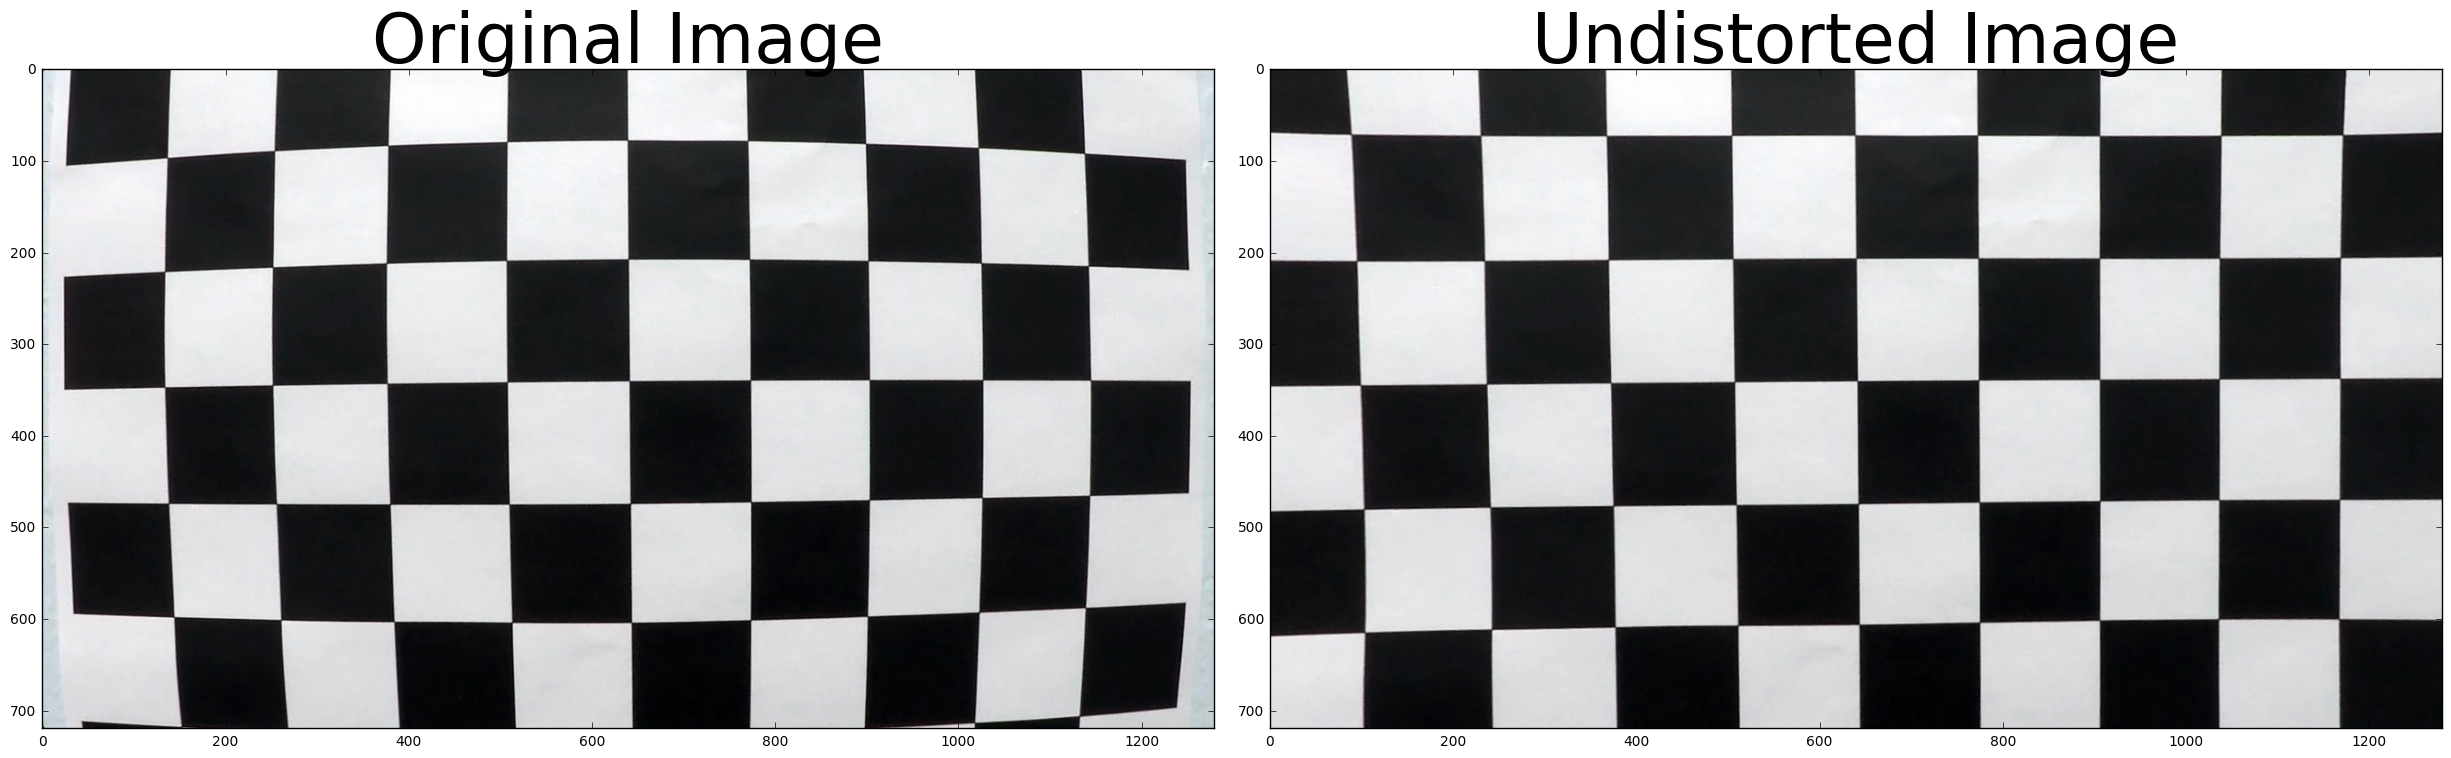

In [1]:
##Code cell 1
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import time
import matplotlib.image as mpmg


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ksize = 3

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    ret,mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
        

img = cv2.imread('./camera_cal/calibration1.jpg')

undistorted = cal_undistort(img, objpoints, imgpoints)
        
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

def abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(0,255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    # 3) Calculate the magnitude
    sobelsqrtx = np.sqrt(np.square(sobelx))
    sobelsqrty = np.sqrt(np.square(sobely))
    sobelsqrtxy = np.absolute(np.sqrt(np.square(sobelx) + np.square(sobely) ))

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelsqrtxy/np.max(sobelsqrtxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    arc_tan = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arc_tan)
    binary_output[(arc_tan >= thresh[0]) & (arc_tan <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output## And so on and so forth...




In [2]:
def process_image(image):
    img = image

    img = cal_undistort(img, objpoints, imgpoints)

    # Threshold x gradient


    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))


    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #print (combined)


    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    top_right_src = [715, 470]
    top_left_src = [565, 470]
    bottom_right_src = [1040, 680]
    bottom_left_src = [265, 680]

    
    top_right_dest = [900, 0]
    top_left_dest = [190, 0]
    bottom_right_dest = [900, 680]
    bottom_left_dest = [190, 680]
# src coordinates
    # src coordinates
    src = np.float32([
        top_right_src, # top right
        bottom_right_src, # bottom right
        bottom_left_src, # bottom left
        top_left_src # top left
    ])

    # dest coordinates
    dst = np.float32([
        top_right_dest, # top right
        bottom_right_dest, # bottom right
        bottom_left_dest, # bottom left
        top_left_dest # top left
    ])



    M = cv2.getPerspectiveTransform(src, dst)



    image_size = (img.shape[1], img.shape[0])
    binary_warped = cv2.warpPerspective(combined_binary, M, image_size, flags=cv2.INTER_LINEAR) 

        # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    center_lane = (leftx_current + rightx_current)/2
    offset = 640 - center_lane
    xm_per_pix = 3.7/700
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


    


    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    left_of_center = offset*xm_per_pix

    text = 'Radius of curvature = '+str(round(left_curverad,2)) + '(m)'
    offset_text = ''
    if round(left_of_center,2) > 0:
        offset_text = 'Vehicle is = ' + str(round(left_of_center,2)) + '(m) right of center'
    else:
        offset_text = 'Vehicle is = ' + str(abs(round(left_of_center,2))) + '(m) left of center'




    print('left')
    print ('left_of_center',left_of_center)
      

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))




    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP ) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.4, 0)
    result = cv2.putText(result,text, (50,100), cv2.FONT_HERSHEY_SIMPLEX,2 , 0,2)
    result = cv2.putText(result,offset_text, (50,200), cv2.FONT_HERSHEY_SIMPLEX,2 , 0,2)

    
    return result

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'final_video1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 

%time white_clip.write_videofile(challenge_output, audio=False)





left
left_of_center 0.1665
[MoviePy] >>>> Building video final_video1.mp4
[MoviePy] Writing video final_video1.mp4


  0%|          | 1/1261 [00:00<17:13,  1.22it/s]

left
left_of_center 0.1665


  0%|          | 2/1261 [00:01<16:56,  1.24it/s]

left
left_of_center 0.163857142857


  0%|          | 3/1261 [00:02<16:37,  1.26it/s]

left
left_of_center 0.163857142857


  0%|          | 4/1261 [00:03<16:21,  1.28it/s]

left
left_of_center 0.158571428571


  0%|          | 5/1261 [00:03<16:10,  1.29it/s]

left
left_of_center 0.158571428571


  0%|          | 6/1261 [00:04<16:23,  1.28it/s]

left
left_of_center 0.145357142857


  1%|          | 7/1261 [00:05<16:57,  1.23it/s]

left
left_of_center 0.169142857143


  1%|          | 8/1261 [00:06<17:00,  1.23it/s]

left
left_of_center 0.208785714286


  1%|          | 9/1261 [00:07<16:46,  1.24it/s]

left
left_of_center 0.206142857143


  1%|          | 10/1261 [00:07<16:33,  1.26it/s]

left
left_of_center 0.200857142857


  1%|          | 11/1261 [00:08<16:18,  1.28it/s]

left
left_of_center 0.206142857143


  1%|          | 12/1261 [00:09<16:10,  1.29it/s]

left
left_of_center 0.198214285714


  1%|          | 13/1261 [00:10<16:02,  1.30it/s]

left
left_of_center 0.187642857143


  1%|          | 14/1261 [00:10<15:53,  1.31it/s]

left
left_of_center 0.177071428571


  1%|          | 15/1261 [00:11<15:51,  1.31it/s]

left
left_of_center 0.187642857143


  1%|▏         | 16/1261 [00:12<15:49,  1.31it/s]

left
left_of_center 0.192928571429


  1%|▏         | 17/1261 [00:13<15:45,  1.32it/s]

left
left_of_center 0.177071428571


  1%|▏         | 18/1261 [00:13<15:45,  1.31it/s]

left
left_of_center 0.195571428571


  2%|▏         | 19/1261 [00:14<15:40,  1.32it/s]

left
left_of_center 0.187642857143


  2%|▏         | 20/1261 [00:15<15:39,  1.32it/s]

left
left_of_center 0.198214285714


  2%|▏         | 21/1261 [00:16<15:36,  1.32it/s]

left
left_of_center 0.266928571429


  2%|▏         | 22/1261 [00:17<15:44,  1.31it/s]

left
left_of_center 0.256357142857


  2%|▏         | 23/1261 [00:17<15:59,  1.29it/s]

left
left_of_center 0.282785714286


  2%|▏         | 24/1261 [00:18<15:58,  1.29it/s]

left
left_of_center 0.272214285714


  2%|▏         | 25/1261 [00:19<15:58,  1.29it/s]

left
left_of_center 0.259


  2%|▏         | 26/1261 [00:20<15:51,  1.30it/s]

left
left_of_center 0.243142857143


  2%|▏         | 27/1261 [00:20<15:49,  1.30it/s]

left
left_of_center 0.243142857143


  2%|▏         | 28/1261 [00:21<15:42,  1.31it/s]

left
left_of_center 0.232571428571


  2%|▏         | 29/1261 [00:22<15:39,  1.31it/s]

left
left_of_center 0.229928571429


  2%|▏         | 30/1261 [00:23<15:51,  1.29it/s]

left
left_of_center 0.232571428571


  2%|▏         | 31/1261 [00:23<15:48,  1.30it/s]

left
left_of_center 0.243142857143


  3%|▎         | 32/1261 [00:24<15:40,  1.31it/s]

left
left_of_center 0.237857142857


  3%|▎         | 33/1261 [00:25<15:34,  1.31it/s]

left
left_of_center 0.261642857143


  3%|▎         | 34/1261 [00:26<15:27,  1.32it/s]

left
left_of_center 0.280142857143


  3%|▎         | 35/1261 [00:26<15:24,  1.33it/s]

left
left_of_center 0.298642857143


  3%|▎         | 36/1261 [00:27<15:25,  1.32it/s]

left
left_of_center 0.290714285714


  3%|▎         | 37/1261 [00:28<15:24,  1.32it/s]

left
left_of_center 0.2775


  3%|▎         | 38/1261 [00:29<15:20,  1.33it/s]

left
left_of_center 0.266928571429


  3%|▎         | 39/1261 [00:29<15:19,  1.33it/s]

left
left_of_center 0.245785714286


  3%|▎         | 40/1261 [00:30<15:16,  1.33it/s]

left
left_of_center 0.248428571429


  3%|▎         | 41/1261 [00:31<15:17,  1.33it/s]

left
left_of_center 0.243142857143


  3%|▎         | 42/1261 [00:32<15:19,  1.33it/s]

left
left_of_center 0.232571428571


  3%|▎         | 43/1261 [00:33<15:38,  1.30it/s]

left
left_of_center 0.200857142857


  3%|▎         | 44/1261 [00:33<15:33,  1.30it/s]

left
left_of_center 0.222


  4%|▎         | 45/1261 [00:34<15:26,  1.31it/s]

left
left_of_center 0.177071428571


  4%|▎         | 46/1261 [00:35<15:21,  1.32it/s]

left
left_of_center 0.264285714286


  4%|▎         | 47/1261 [00:36<15:17,  1.32it/s]

left
left_of_center 0.256357142857


  4%|▍         | 48/1261 [00:36<15:17,  1.32it/s]

left
left_of_center 0.272214285714


  4%|▍         | 49/1261 [00:37<15:14,  1.33it/s]

left
left_of_center 0.251071428571


  4%|▍         | 50/1261 [00:38<15:15,  1.32it/s]

left
left_of_center 0.235214285714


  4%|▍         | 51/1261 [00:39<15:14,  1.32it/s]

left
left_of_center 0.229928571429


  4%|▍         | 52/1261 [00:39<15:12,  1.33it/s]

left
left_of_center 0.232571428571


  4%|▍         | 53/1261 [00:40<15:21,  1.31it/s]

left
left_of_center 0.227285714286


  4%|▍         | 54/1261 [00:41<15:16,  1.32it/s]

left
left_of_center 0.232571428571


  4%|▍         | 55/1261 [00:42<15:14,  1.32it/s]

left
left_of_center 0.219357142857


  4%|▍         | 56/1261 [00:42<15:13,  1.32it/s]

left
left_of_center 0.227285714286


  5%|▍         | 57/1261 [00:43<15:09,  1.32it/s]

left
left_of_center 0.206142857143


  5%|▍         | 58/1261 [00:44<15:07,  1.33it/s]

left
left_of_center 0.298642857143


  5%|▍         | 59/1261 [00:45<15:01,  1.33it/s]

left
left_of_center 0.288071428571


  5%|▍         | 60/1261 [00:45<15:01,  1.33it/s]

left
left_of_center 0.335642857143


  5%|▍         | 61/1261 [00:46<15:01,  1.33it/s]

left
left_of_center 0.340928571429


  5%|▍         | 62/1261 [00:47<15:03,  1.33it/s]

left
left_of_center 0.319785714286


  5%|▍         | 63/1261 [00:48<15:01,  1.33it/s]

left
left_of_center 0.3145


  5%|▌         | 64/1261 [00:48<15:12,  1.31it/s]

left
left_of_center 0.296


  5%|▌         | 65/1261 [00:49<15:06,  1.32it/s]

left
left_of_center 0.290714285714


  5%|▌         | 66/1261 [00:50<15:13,  1.31it/s]

left
left_of_center 0.290714285714


  5%|▌         | 67/1261 [00:51<15:08,  1.31it/s]

left
left_of_center 0.290714285714


  5%|▌         | 68/1261 [00:51<15:10,  1.31it/s]

left
left_of_center 0.293357142857


  5%|▌         | 69/1261 [00:52<15:07,  1.31it/s]

left
left_of_center 0.303928571429


  6%|▌         | 70/1261 [00:53<15:04,  1.32it/s]

left
left_of_center 0.272214285714


  6%|▌         | 71/1261 [00:54<15:02,  1.32it/s]

left
left_of_center 0.449285714286


  6%|▌         | 72/1261 [00:55<15:02,  1.32it/s]

left
left_of_center 0.433428571429


  6%|▌         | 73/1261 [00:55<14:59,  1.32it/s]

left
left_of_center 0.401714285714


  6%|▌         | 74/1261 [00:56<15:01,  1.32it/s]

left
left_of_center 0.393785714286


  6%|▌         | 75/1261 [00:57<14:58,  1.32it/s]

left
left_of_center 0.383214285714


  6%|▌         | 76/1261 [00:58<14:57,  1.32it/s]

left
left_of_center 0.399071428571


  6%|▌         | 77/1261 [00:58<14:57,  1.32it/s]

left
left_of_center 0.375285714286


  6%|▌         | 78/1261 [00:59<14:52,  1.32it/s]

left
left_of_center 0.3515


  6%|▋         | 79/1261 [01:00<14:54,  1.32it/s]

left
left_of_center 0.354142857143


  6%|▋         | 80/1261 [01:01<14:52,  1.32it/s]

left
left_of_center 0.333


  6%|▋         | 81/1261 [01:01<14:50,  1.32it/s]

left
left_of_center 0.3515


  7%|▋         | 82/1261 [01:02<14:48,  1.33it/s]

left
left_of_center 0.346214285714


  7%|▋         | 83/1261 [01:03<14:48,  1.33it/s]

left
left_of_center 0.37


  7%|▋         | 84/1261 [01:04<14:47,  1.33it/s]

left
left_of_center 0.3885


  7%|▋         | 85/1261 [01:04<14:49,  1.32it/s]

left
left_of_center 0.377928571429


  7%|▋         | 86/1261 [01:05<14:54,  1.31it/s]

left
left_of_center 0.393785714286


  7%|▋         | 87/1261 [01:06<14:51,  1.32it/s]

left
left_of_center 0.385857142857


  7%|▋         | 88/1261 [01:07<14:51,  1.32it/s]

left
left_of_center 0.3885


  7%|▋         | 89/1261 [01:07<14:55,  1.31it/s]

left
left_of_center 0.3885


  7%|▋         | 90/1261 [01:08<14:53,  1.31it/s]

left
left_of_center 0.383214285714


  7%|▋         | 91/1261 [01:09<15:18,  1.27it/s]

left
left_of_center 0.383214285714


  7%|▋         | 92/1261 [01:10<16:04,  1.21it/s]

left
left_of_center 0.367357142857


  7%|▋         | 93/1261 [01:11<16:31,  1.18it/s]

left
left_of_center 0.362071428571


  7%|▋         | 94/1261 [01:12<16:21,  1.19it/s]

left
left_of_center 0.37


  8%|▊         | 95/1261 [01:12<15:54,  1.22it/s]

left
left_of_center 0.356785714286


  8%|▊         | 96/1261 [01:13<15:29,  1.25it/s]

left
left_of_center 0.430785714286


  8%|▊         | 97/1261 [01:14<15:15,  1.27it/s]

left
left_of_center 0.414928571429


  8%|▊         | 98/1261 [01:15<15:02,  1.29it/s]

left
left_of_center 0.407


  8%|▊         | 99/1261 [01:15<14:58,  1.29it/s]

left
left_of_center 0.438714285714


  8%|▊         | 100/1261 [01:16<14:54,  1.30it/s]

left
left_of_center 0.428142857143


  8%|▊         | 101/1261 [01:17<14:58,  1.29it/s]

left
left_of_center 0.407


  8%|▊         | 102/1261 [01:18<14:57,  1.29it/s]

left
left_of_center 0.399071428571


  8%|▊         | 103/1261 [01:19<14:55,  1.29it/s]

left
left_of_center 0.3885


  8%|▊         | 104/1261 [01:19<14:56,  1.29it/s]

left
left_of_center 0.377928571429


  8%|▊         | 105/1261 [01:20<14:56,  1.29it/s]

left
left_of_center 0.362071428571


  8%|▊         | 106/1261 [01:21<14:50,  1.30it/s]

left
left_of_center 0.362071428571


  8%|▊         | 107/1261 [01:22<14:45,  1.30it/s]

left
left_of_center 0.346214285714


  9%|▊         | 108/1261 [01:22<14:45,  1.30it/s]

left
left_of_center 0.335642857143


  9%|▊         | 109/1261 [01:23<14:47,  1.30it/s]

left
left_of_center 0.338285714286


  9%|▊         | 110/1261 [01:24<14:50,  1.29it/s]

left
left_of_center 0.335642857143


  9%|▉         | 111/1261 [01:25<14:40,  1.31it/s]

left
left_of_center 0.340928571429


  9%|▉         | 112/1261 [01:25<14:36,  1.31it/s]

left
left_of_center 0.3145


  9%|▉         | 113/1261 [01:26<14:31,  1.32it/s]

left
left_of_center 0.309214285714


  9%|▉         | 114/1261 [01:27<14:29,  1.32it/s]

left
left_of_center 0.338285714286


  9%|▉         | 115/1261 [01:28<14:26,  1.32it/s]

left
left_of_center 0.327714285714


  9%|▉         | 116/1261 [01:28<14:25,  1.32it/s]

left
left_of_center 0.301285714286


  9%|▉         | 117/1261 [01:29<14:29,  1.32it/s]

left
left_of_center 0.296


  9%|▉         | 118/1261 [01:30<14:29,  1.31it/s]

left
left_of_center 0.306571428571


  9%|▉         | 119/1261 [01:31<14:25,  1.32it/s]

left
left_of_center 0.274857142857


 10%|▉         | 120/1261 [01:31<14:20,  1.33it/s]

left
left_of_center 0.269571428571


 10%|▉         | 121/1261 [01:32<14:39,  1.30it/s]

left
left_of_center 0.3145


 10%|▉         | 122/1261 [01:33<14:47,  1.28it/s]

left
left_of_center 0.293357142857


 10%|▉         | 123/1261 [01:34<14:42,  1.29it/s]

left
left_of_center 0.293357142857


 10%|▉         | 124/1261 [01:35<14:35,  1.30it/s]

left
left_of_center 0.280142857143


 10%|▉         | 125/1261 [01:35<14:28,  1.31it/s]

left
left_of_center 0.259


 10%|▉         | 126/1261 [01:36<14:22,  1.32it/s]

left
left_of_center 0.237857142857


 10%|█         | 127/1261 [01:37<14:23,  1.31it/s]

left
left_of_center 0.2035


 10%|█         | 128/1261 [01:38<14:18,  1.32it/s]

left
left_of_center 0.2775


 10%|█         | 129/1261 [01:38<14:19,  1.32it/s]

left
left_of_center 0.261642857143


 10%|█         | 130/1261 [01:39<14:17,  1.32it/s]

left
left_of_center 0.2405


 10%|█         | 131/1261 [01:40<14:14,  1.32it/s]

left
left_of_center 0.245785714286


 10%|█         | 132/1261 [01:41<14:10,  1.33it/s]

left
left_of_center 0.208785714286


 11%|█         | 133/1261 [01:41<14:17,  1.31it/s]

left
left_of_center 0.206142857143


 11%|█         | 134/1261 [01:42<14:18,  1.31it/s]

left
left_of_center 0.266928571429


 11%|█         | 135/1261 [01:43<14:23,  1.30it/s]

left
left_of_center 0.251071428571


 11%|█         | 136/1261 [01:44<14:19,  1.31it/s]

left
left_of_center 0.253714285714


 11%|█         | 137/1261 [01:44<14:22,  1.30it/s]

left
left_of_center 0.256357142857


 11%|█         | 138/1261 [01:45<14:18,  1.31it/s]

left
left_of_center 0.227285714286


 11%|█         | 139/1261 [01:46<14:20,  1.30it/s]

left
left_of_center 0.222


 11%|█         | 140/1261 [01:47<14:12,  1.31it/s]

left
left_of_center 0.208785714286


 11%|█         | 141/1261 [01:48<14:17,  1.31it/s]

left
left_of_center 0.200857142857


 11%|█▏        | 142/1261 [01:48<14:15,  1.31it/s]

left
left_of_center 0.192928571429


 11%|█▏        | 143/1261 [01:49<14:15,  1.31it/s]

left
left_of_center 0.187642857143


 11%|█▏        | 144/1261 [01:50<14:15,  1.31it/s]

left
left_of_center 0.211428571429


 11%|█▏        | 145/1261 [01:51<14:13,  1.31it/s]

left
left_of_center 0.169142857143


 12%|█▏        | 146/1261 [01:51<14:13,  1.31it/s]

left
left_of_center 0.264285714286


 12%|█▏        | 147/1261 [01:52<14:13,  1.31it/s]

left
left_of_center 0.251071428571


 12%|█▏        | 148/1261 [01:53<14:12,  1.31it/s]

left
left_of_center 0.290714285714


 12%|█▏        | 149/1261 [01:54<14:10,  1.31it/s]

left
left_of_center 0.261642857143


 12%|█▏        | 150/1261 [01:54<14:05,  1.31it/s]

left
left_of_center 0.282785714286


 12%|█▏        | 151/1261 [01:55<14:08,  1.31it/s]

left
left_of_center 0.253714285714


 12%|█▏        | 152/1261 [01:56<14:04,  1.31it/s]

left
left_of_center 0.248428571429


 12%|█▏        | 153/1261 [01:57<14:04,  1.31it/s]

left
left_of_center 0.2405


 12%|█▏        | 154/1261 [01:57<14:00,  1.32it/s]

left
left_of_center 0.222


 12%|█▏        | 155/1261 [01:58<14:02,  1.31it/s]

left
left_of_center 0.2405


 12%|█▏        | 156/1261 [01:59<13:54,  1.32it/s]

left
left_of_center 0.222


 12%|█▏        | 157/1261 [02:00<13:56,  1.32it/s]

left
left_of_center 0.219357142857


 13%|█▎        | 158/1261 [02:00<13:54,  1.32it/s]

left
left_of_center 0.216714285714


 13%|█▎        | 159/1261 [02:01<13:50,  1.33it/s]

left
left_of_center 0.293357142857


 13%|█▎        | 160/1261 [02:02<13:46,  1.33it/s]

left
left_of_center 0.285428571429


 13%|█▎        | 161/1261 [02:03<13:48,  1.33it/s]

left
left_of_center 0.293357142857


 13%|█▎        | 162/1261 [02:03<13:49,  1.32it/s]

left
left_of_center 0.293357142857


 13%|█▎        | 163/1261 [02:04<13:47,  1.33it/s]

left
left_of_center 0.288071428571


 13%|█▎        | 164/1261 [02:05<13:47,  1.33it/s]

left
left_of_center 0.2775


 13%|█▎        | 165/1261 [02:06<13:47,  1.32it/s]

left
left_of_center 0.285428571429


 13%|█▎        | 166/1261 [02:07<13:51,  1.32it/s]

left
left_of_center 0.274857142857


 13%|█▎        | 167/1261 [02:07<13:45,  1.33it/s]

left
left_of_center 0.2775


 13%|█▎        | 168/1261 [02:08<13:44,  1.32it/s]

left
left_of_center 0.274857142857


 13%|█▎        | 169/1261 [02:09<13:44,  1.32it/s]

left
left_of_center 0.269571428571


 13%|█▎        | 170/1261 [02:10<13:43,  1.32it/s]

left
left_of_center 0.253714285714


 14%|█▎        | 171/1261 [02:10<13:40,  1.33it/s]

left
left_of_center 0.338285714286


 14%|█▎        | 172/1261 [02:11<13:41,  1.32it/s]

left
left_of_center 0.343571428571


 14%|█▎        | 173/1261 [02:12<13:41,  1.32it/s]

left
left_of_center 0.348857142857


 14%|█▍        | 174/1261 [02:13<13:37,  1.33it/s]

left
left_of_center 0.377928571429


 14%|█▍        | 175/1261 [02:13<13:40,  1.32it/s]

left
left_of_center 0.385857142857


 14%|█▍        | 176/1261 [02:14<13:42,  1.32it/s]

left
left_of_center 0.354142857143


 14%|█▍        | 177/1261 [02:15<13:40,  1.32it/s]

left
left_of_center 0.322428571429


 14%|█▍        | 178/1261 [02:16<13:39,  1.32it/s]

left
left_of_center 0.3515


 14%|█▍        | 179/1261 [02:16<13:42,  1.32it/s]

left
left_of_center 0.327714285714


 14%|█▍        | 180/1261 [02:17<13:49,  1.30it/s]

left
left_of_center 0.317142857143


 14%|█▍        | 181/1261 [02:18<13:49,  1.30it/s]

left
left_of_center 0.3145


 14%|█▍        | 182/1261 [02:19<13:54,  1.29it/s]

left
left_of_center 0.330357142857


 15%|█▍        | 183/1261 [02:19<13:54,  1.29it/s]

left
left_of_center 0.333


 15%|█▍        | 184/1261 [02:20<13:56,  1.29it/s]

left
left_of_center 0.343571428571


 15%|█▍        | 185/1261 [02:21<13:54,  1.29it/s]

left
left_of_center 0.330357142857


 15%|█▍        | 186/1261 [02:22<13:46,  1.30it/s]

left
left_of_center 0.367357142857


 15%|█▍        | 187/1261 [02:23<13:42,  1.31it/s]

left
left_of_center 0.377928571429


 15%|█▍        | 188/1261 [02:23<13:41,  1.31it/s]

left
left_of_center 0.346214285714


 15%|█▍        | 189/1261 [02:24<13:41,  1.30it/s]

left
left_of_center 0.3145


 15%|█▌        | 190/1261 [02:25<13:52,  1.29it/s]

left
left_of_center 0.306571428571


 15%|█▌        | 191/1261 [02:26<13:46,  1.29it/s]

left
left_of_center 0.293357142857


 15%|█▌        | 192/1261 [02:26<13:37,  1.31it/s]

left
left_of_center 0.245785714286


 15%|█▌        | 193/1261 [02:27<13:33,  1.31it/s]

left
left_of_center 0.288071428571


 15%|█▌        | 194/1261 [02:28<13:33,  1.31it/s]

left
left_of_center 0.222


 15%|█▌        | 195/1261 [02:29<13:30,  1.31it/s]

left
left_of_center 0.333


 16%|█▌        | 196/1261 [02:29<13:26,  1.32it/s]

left
left_of_center 0.309214285714


 16%|█▌        | 197/1261 [02:30<13:24,  1.32it/s]

left
left_of_center 0.282785714286


 16%|█▌        | 198/1261 [02:31<13:23,  1.32it/s]

left
left_of_center 0.269571428571


 16%|█▌        | 199/1261 [02:32<13:22,  1.32it/s]

left
left_of_center 0.266928571429


 16%|█▌        | 200/1261 [02:32<13:19,  1.33it/s]

left
left_of_center 0.280142857143


 16%|█▌        | 201/1261 [02:33<13:21,  1.32it/s]

left
left_of_center 0.301285714286


 16%|█▌        | 202/1261 [02:34<13:20,  1.32it/s]

left
left_of_center 0.293357142857


 16%|█▌        | 203/1261 [02:35<13:23,  1.32it/s]

left
left_of_center 0.298642857143


 16%|█▌        | 204/1261 [02:35<13:21,  1.32it/s]

left
left_of_center 0.296


 16%|█▋        | 205/1261 [02:36<13:20,  1.32it/s]

left
left_of_center 0.306571428571


 16%|█▋        | 206/1261 [02:37<13:15,  1.33it/s]

left
left_of_center 0.301285714286


 16%|█▋        | 207/1261 [02:38<13:18,  1.32it/s]

left
left_of_center 0.298642857143


 16%|█▋        | 208/1261 [02:38<13:14,  1.33it/s]

left
left_of_center 0.362071428571


 17%|█▋        | 209/1261 [02:39<13:16,  1.32it/s]

left
left_of_center 0.338285714286


 17%|█▋        | 210/1261 [02:40<13:13,  1.32it/s]

left
left_of_center 0.325071428571


 17%|█▋        | 211/1261 [02:41<13:16,  1.32it/s]

left
left_of_center 0.362071428571


 17%|█▋        | 212/1261 [02:42<13:17,  1.32it/s]

left
left_of_center 0.298642857143


 17%|█▋        | 213/1261 [02:42<13:15,  1.32it/s]

left
left_of_center 0.290714285714


 17%|█▋        | 214/1261 [02:43<13:11,  1.32it/s]

left
left_of_center 0.311857142857


 17%|█▋        | 215/1261 [02:44<13:09,  1.33it/s]

left
left_of_center 0.311857142857


 17%|█▋        | 216/1261 [02:45<13:11,  1.32it/s]

left
left_of_center 0.335642857143


 17%|█▋        | 217/1261 [02:45<13:09,  1.32it/s]

left
left_of_center 0.327714285714


 17%|█▋        | 218/1261 [02:46<13:07,  1.32it/s]

left
left_of_center 0.327714285714


 17%|█▋        | 219/1261 [02:47<13:07,  1.32it/s]

left
left_of_center 0.346214285714


 17%|█▋        | 220/1261 [02:48<13:04,  1.33it/s]

left
left_of_center 0.407


 18%|█▊        | 221/1261 [02:48<13:00,  1.33it/s]

left
left_of_center 0.393785714286


 18%|█▊        | 222/1261 [02:49<13:01,  1.33it/s]

left
left_of_center 0.372642857143


 18%|█▊        | 223/1261 [02:50<13:07,  1.32it/s]

left
left_of_center 0.412285714286


 18%|█▊        | 224/1261 [02:51<13:05,  1.32it/s]

left
left_of_center 0.414928571429


 18%|█▊        | 225/1261 [02:51<13:01,  1.33it/s]

left
left_of_center 0.401714285714


 18%|█▊        | 226/1261 [02:52<13:02,  1.32it/s]

left
left_of_center 0.401714285714


 18%|█▊        | 227/1261 [02:53<13:01,  1.32it/s]

left
left_of_center 0.383214285714


 18%|█▊        | 228/1261 [02:54<12:59,  1.33it/s]

left
left_of_center 0.37


 18%|█▊        | 229/1261 [02:54<13:00,  1.32it/s]

left
left_of_center 0.367357142857


 18%|█▊        | 230/1261 [02:55<12:59,  1.32it/s]

left
left_of_center 0.385857142857


 18%|█▊        | 231/1261 [02:56<12:58,  1.32it/s]

left
left_of_center 0.377928571429


 18%|█▊        | 232/1261 [02:57<13:01,  1.32it/s]

left
left_of_center 0.404357142857


 18%|█▊        | 233/1261 [02:57<13:04,  1.31it/s]

left
left_of_center 0.459857142857


 19%|█▊        | 234/1261 [02:58<13:03,  1.31it/s]

left
left_of_center 0.4625


 19%|█▊        | 235/1261 [02:59<13:04,  1.31it/s]

left
left_of_center 0.491571428571


 19%|█▊        | 236/1261 [03:00<13:01,  1.31it/s]

left
left_of_center 0.478357142857


 19%|█▉        | 237/1261 [03:00<13:01,  1.31it/s]

left
left_of_center 0.446642857143


 19%|█▉        | 238/1261 [03:01<13:02,  1.31it/s]

left
left_of_center 0.465142857143


 19%|█▉        | 239/1261 [03:02<13:02,  1.31it/s]

left
left_of_center 0.454571428571


 19%|█▉        | 240/1261 [03:03<12:58,  1.31it/s]

left
left_of_center 0.459857142857


 19%|█▉        | 241/1261 [03:04<13:02,  1.30it/s]

left
left_of_center 0.454571428571


 19%|█▉        | 242/1261 [03:04<12:57,  1.31it/s]

left
left_of_center 0.441357142857


 19%|█▉        | 243/1261 [03:05<12:52,  1.32it/s]

left
left_of_center 0.436071428571


 19%|█▉        | 244/1261 [03:06<12:49,  1.32it/s]

left
left_of_center 0.438714285714


 19%|█▉        | 245/1261 [03:07<12:51,  1.32it/s]

left
left_of_center 0.510071428571


 20%|█▉        | 246/1261 [03:07<12:51,  1.32it/s]

left
left_of_center 0.502142857143


 20%|█▉        | 247/1261 [03:08<12:48,  1.32it/s]

left
left_of_center 0.539142857143


 20%|█▉        | 248/1261 [03:09<12:47,  1.32it/s]

left
left_of_center 0.539142857143


 20%|█▉        | 249/1261 [03:10<12:46,  1.32it/s]

left
left_of_center 0.510071428571


 20%|█▉        | 250/1261 [03:10<12:47,  1.32it/s]

left
left_of_center 0.510071428571


 20%|█▉        | 251/1261 [03:11<12:44,  1.32it/s]

left
left_of_center 0.494214285714


 20%|█▉        | 252/1261 [03:12<12:43,  1.32it/s]

left
left_of_center 0.510071428571


 20%|██        | 253/1261 [03:13<12:44,  1.32it/s]

left
left_of_center 0.494214285714


 20%|██        | 254/1261 [03:13<12:42,  1.32it/s]

left
left_of_center 0.470428571429


 20%|██        | 255/1261 [03:14<12:41,  1.32it/s]

left
left_of_center 0.449285714286


 20%|██        | 256/1261 [03:15<12:38,  1.32it/s]

left
left_of_center 0.438714285714


 20%|██        | 257/1261 [03:16<12:42,  1.32it/s]

left
left_of_center 0.518


 20%|██        | 258/1261 [03:16<12:41,  1.32it/s]

left
left_of_center 0.518


 21%|██        | 259/1261 [03:17<12:51,  1.30it/s]

left
left_of_center 0.502142857143


 21%|██        | 260/1261 [03:18<12:46,  1.31it/s]

left
left_of_center 0.494214285714


 21%|██        | 261/1261 [03:19<12:51,  1.30it/s]

left
left_of_center 0.473071428571


 21%|██        | 262/1261 [03:20<12:52,  1.29it/s]

left
left_of_center 0.491571428571


 21%|██        | 263/1261 [03:20<12:56,  1.29it/s]

left
left_of_center 0.449285714286


 21%|██        | 264/1261 [03:21<12:45,  1.30it/s]

left
left_of_center 0.470428571429


 21%|██        | 265/1261 [03:22<12:41,  1.31it/s]

left
left_of_center 0.457214285714


 21%|██        | 266/1261 [03:23<12:53,  1.29it/s]

left
left_of_center 0.409642857143


 21%|██        | 267/1261 [03:23<13:16,  1.25it/s]

left
left_of_center 0.446642857143


 21%|██▏       | 268/1261 [03:24<13:06,  1.26it/s]

left
left_of_center 0.451928571429


 21%|██▏       | 269/1261 [03:25<13:02,  1.27it/s]

left
left_of_center 0.449285714286


 21%|██▏       | 270/1261 [03:26<13:11,  1.25it/s]

left
left_of_center 0.446642857143


 21%|██▏       | 271/1261 [03:27<13:12,  1.25it/s]

left
left_of_center 0.454571428571


 22%|██▏       | 272/1261 [03:27<13:24,  1.23it/s]

left
left_of_center 0.4625


 22%|██▏       | 273/1261 [03:28<13:11,  1.25it/s]

left
left_of_center 0.449285714286


 22%|██▏       | 274/1261 [03:29<12:55,  1.27it/s]

left
left_of_center 0.428142857143


 22%|██▏       | 275/1261 [03:30<12:48,  1.28it/s]

left
left_of_center 0.414928571429


 22%|██▏       | 276/1261 [03:31<12:38,  1.30it/s]

left
left_of_center 0.409642857143


 22%|██▏       | 277/1261 [03:31<12:34,  1.30it/s]

left
left_of_center 0.399071428571


 22%|██▏       | 278/1261 [03:32<12:28,  1.31it/s]

left
left_of_center 0.414928571429


 22%|██▏       | 279/1261 [03:33<12:28,  1.31it/s]

left
left_of_center 0.396428571429


 22%|██▏       | 280/1261 [03:34<12:25,  1.32it/s]

left
left_of_center 0.383214285714


 22%|██▏       | 281/1261 [03:34<12:26,  1.31it/s]

left
left_of_center 0.420214285714


 22%|██▏       | 282/1261 [03:35<12:24,  1.32it/s]

left
left_of_center 0.430785714286


 22%|██▏       | 283/1261 [03:36<12:19,  1.32it/s]

left
left_of_center 0.404357142857


 23%|██▎       | 284/1261 [03:37<12:17,  1.32it/s]

left
left_of_center 0.399071428571


 23%|██▎       | 285/1261 [03:37<12:20,  1.32it/s]

left
left_of_center 0.396428571429


 23%|██▎       | 286/1261 [03:38<12:21,  1.32it/s]

left
left_of_center 0.327714285714


 23%|██▎       | 287/1261 [03:39<12:18,  1.32it/s]

left
left_of_center 0.335642857143


 23%|██▎       | 288/1261 [03:40<12:21,  1.31it/s]

left
left_of_center 0.356785714286


 23%|██▎       | 289/1261 [03:40<12:21,  1.31it/s]

left
left_of_center 0.3515


 23%|██▎       | 290/1261 [03:41<12:22,  1.31it/s]

left
left_of_center 0.309214285714


 23%|██▎       | 291/1261 [03:42<12:18,  1.31it/s]

left
left_of_center 0.301285714286


 23%|██▎       | 292/1261 [03:43<12:23,  1.30it/s]

left
left_of_center 0.354142857143


 23%|██▎       | 293/1261 [03:43<12:23,  1.30it/s]

left
left_of_center 0.375285714286


 23%|██▎       | 294/1261 [03:44<12:22,  1.30it/s]

left
left_of_center 0.37


 23%|██▎       | 295/1261 [03:45<12:15,  1.31it/s]

left
left_of_center 0.362071428571


 23%|██▎       | 296/1261 [03:46<12:11,  1.32it/s]

left
left_of_center 0.356785714286


 24%|██▎       | 297/1261 [03:46<12:10,  1.32it/s]

left
left_of_center 0.333


 24%|██▎       | 298/1261 [03:47<12:10,  1.32it/s]

left
left_of_center 0.311857142857


 24%|██▎       | 299/1261 [03:48<12:08,  1.32it/s]

left
left_of_center 0.335642857143


 24%|██▍       | 300/1261 [03:49<12:08,  1.32it/s]

left
left_of_center 0.317142857143


 24%|██▍       | 301/1261 [03:50<12:06,  1.32it/s]

left
left_of_center 0.309214285714


 24%|██▍       | 302/1261 [03:50<12:16,  1.30it/s]

left
left_of_center 0.301285714286


 24%|██▍       | 303/1261 [03:51<12:11,  1.31it/s]

left
left_of_center 0.303928571429


 24%|██▍       | 304/1261 [03:52<12:10,  1.31it/s]

left
left_of_center 0.333


 24%|██▍       | 305/1261 [03:53<12:06,  1.32it/s]

left
left_of_center 0.330357142857


 24%|██▍       | 306/1261 [03:53<12:02,  1.32it/s]

left
left_of_center 0.335642857143


 24%|██▍       | 307/1261 [03:54<12:00,  1.32it/s]

left
left_of_center 0.3145


 24%|██▍       | 308/1261 [03:55<12:11,  1.30it/s]

left
left_of_center 0.340928571429


 25%|██▍       | 309/1261 [03:56<12:05,  1.31it/s]

left
left_of_center 0.298642857143


 25%|██▍       | 310/1261 [03:56<12:06,  1.31it/s]

left
left_of_center 0.282785714286


 25%|██▍       | 311/1261 [03:57<12:05,  1.31it/s]

left
left_of_center 0.285428571429


 25%|██▍       | 312/1261 [03:58<12:03,  1.31it/s]

left
left_of_center 0.311857142857


 25%|██▍       | 313/1261 [03:59<12:00,  1.32it/s]

left
left_of_center 0.290714285714


 25%|██▍       | 314/1261 [03:59<11:59,  1.32it/s]

left
left_of_center 0.301285714286


 25%|██▍       | 315/1261 [04:00<11:55,  1.32it/s]

left
left_of_center 0.290714285714


 25%|██▌       | 316/1261 [04:01<11:56,  1.32it/s]

left
left_of_center 0.3145


 25%|██▌       | 317/1261 [04:02<11:54,  1.32it/s]

left
left_of_center 0.317142857143


 25%|██▌       | 318/1261 [04:02<11:55,  1.32it/s]

left
left_of_center 0.372642857143


 25%|██▌       | 319/1261 [04:03<11:52,  1.32it/s]

left
left_of_center 0.301285714286


 25%|██▌       | 320/1261 [04:04<11:50,  1.32it/s]

left
left_of_center 0.335642857143


 25%|██▌       | 321/1261 [04:05<11:50,  1.32it/s]

left
left_of_center 0.298642857143


 26%|██▌       | 322/1261 [04:05<11:51,  1.32it/s]

left
left_of_center 0.296


 26%|██▌       | 323/1261 [04:06<11:48,  1.32it/s]

left
left_of_center 0.3145


 26%|██▌       | 324/1261 [04:07<11:47,  1.32it/s]

left
left_of_center 0.309214285714


 26%|██▌       | 325/1261 [04:08<11:45,  1.33it/s]

left
left_of_center 0.298642857143


 26%|██▌       | 326/1261 [04:08<11:47,  1.32it/s]

left
left_of_center 0.298642857143


 26%|██▌       | 327/1261 [04:09<11:47,  1.32it/s]

left
left_of_center 0.306571428571


 26%|██▌       | 328/1261 [04:10<11:45,  1.32it/s]

left
left_of_center 0.306571428571


 26%|██▌       | 329/1261 [04:11<11:42,  1.33it/s]

left
left_of_center 0.317142857143


 26%|██▌       | 330/1261 [04:12<11:44,  1.32it/s]

left
left_of_center 0.327714285714


 26%|██▌       | 331/1261 [04:12<11:47,  1.31it/s]

left
left_of_center 0.3145


 26%|██▋       | 332/1261 [04:13<11:51,  1.31it/s]

left
left_of_center 0.317142857143


 26%|██▋       | 333/1261 [04:14<11:47,  1.31it/s]

left
left_of_center 0.3145


 26%|██▋       | 334/1261 [04:15<11:48,  1.31it/s]

left
left_of_center 0.2775


 27%|██▋       | 335/1261 [04:15<11:43,  1.32it/s]

left
left_of_center 0.303928571429


 27%|██▋       | 336/1261 [04:16<11:40,  1.32it/s]

left
left_of_center 0.256357142857


 27%|██▋       | 337/1261 [04:17<11:50,  1.30it/s]

left
left_of_center 0.293357142857


 27%|██▋       | 338/1261 [04:18<11:56,  1.29it/s]

left
left_of_center 0.288071428571


 27%|██▋       | 339/1261 [04:18<11:57,  1.28it/s]

left
left_of_center 0.282785714286


 27%|██▋       | 340/1261 [04:19<11:58,  1.28it/s]

left
left_of_center 0.288071428571


 27%|██▋       | 341/1261 [04:20<11:49,  1.30it/s]

left
left_of_center 0.269571428571


 27%|██▋       | 342/1261 [04:21<11:50,  1.29it/s]

left
left_of_center 0.288071428571


 27%|██▋       | 343/1261 [04:22<11:51,  1.29it/s]

left
left_of_center 0.290714285714


 27%|██▋       | 344/1261 [04:22<11:58,  1.28it/s]

left
left_of_center 0.296


 27%|██▋       | 345/1261 [04:23<11:58,  1.28it/s]

left
left_of_center 0.296


 27%|██▋       | 346/1261 [04:24<11:54,  1.28it/s]

left
left_of_center 0.293357142857


 28%|██▊       | 347/1261 [04:25<11:44,  1.30it/s]

left
left_of_center 0.290714285714


 28%|██▊       | 348/1261 [04:25<11:41,  1.30it/s]

left
left_of_center 0.288071428571


 28%|██▊       | 349/1261 [04:26<11:45,  1.29it/s]

left
left_of_center 0.285428571429


 28%|██▊       | 350/1261 [04:27<11:45,  1.29it/s]

left
left_of_center 0.2775


 28%|██▊       | 351/1261 [04:28<11:39,  1.30it/s]

left
left_of_center 0.282785714286


 28%|██▊       | 352/1261 [04:29<11:40,  1.30it/s]

left
left_of_center 0.280142857143


 28%|██▊       | 353/1261 [04:29<11:39,  1.30it/s]

left
left_of_center 0.309214285714


 28%|██▊       | 354/1261 [04:30<11:38,  1.30it/s]

left
left_of_center 0.293357142857


 28%|██▊       | 355/1261 [04:31<11:35,  1.30it/s]

left
left_of_center 0.288071428571


 28%|██▊       | 356/1261 [04:32<11:33,  1.30it/s]

left
left_of_center 0.293357142857


 28%|██▊       | 357/1261 [04:32<11:30,  1.31it/s]

left
left_of_center 0.288071428571


 28%|██▊       | 358/1261 [04:33<11:27,  1.31it/s]

left
left_of_center 0.274857142857


 28%|██▊       | 359/1261 [04:34<11:27,  1.31it/s]

left
left_of_center 0.282785714286


 29%|██▊       | 360/1261 [04:35<11:24,  1.32it/s]

left
left_of_center 0.272214285714


 29%|██▊       | 361/1261 [04:35<11:24,  1.32it/s]

left
left_of_center 0.2775


 29%|██▊       | 362/1261 [04:36<11:25,  1.31it/s]

left
left_of_center 0.2775


 29%|██▉       | 363/1261 [04:37<11:23,  1.31it/s]

left
left_of_center 0.229928571429


 29%|██▉       | 364/1261 [04:38<11:21,  1.32it/s]

left
left_of_center 0.259


 29%|██▉       | 365/1261 [04:38<11:21,  1.32it/s]

left
left_of_center 0.253714285714


 29%|██▉       | 366/1261 [04:39<11:20,  1.31it/s]

left
left_of_center 0.245785714286


 29%|██▉       | 367/1261 [04:40<11:20,  1.31it/s]

left
left_of_center 0.280142857143


 29%|██▉       | 368/1261 [04:41<11:21,  1.31it/s]

left
left_of_center 0.272214285714


 29%|██▉       | 369/1261 [04:41<11:18,  1.32it/s]

left
left_of_center 0.269571428571


 29%|██▉       | 370/1261 [04:42<11:19,  1.31it/s]

left
left_of_center 0.266928571429


 29%|██▉       | 371/1261 [04:43<11:17,  1.31it/s]

left
left_of_center 0.229928571429


 30%|██▉       | 372/1261 [04:44<11:16,  1.31it/s]

left
left_of_center 0.245785714286


 30%|██▉       | 373/1261 [04:44<11:12,  1.32it/s]

left
left_of_center 0.280142857143


 30%|██▉       | 374/1261 [04:45<11:13,  1.32it/s]

left
left_of_center 0.282785714286


 30%|██▉       | 375/1261 [04:46<11:11,  1.32it/s]

left
left_of_center 0.296


 30%|██▉       | 376/1261 [04:47<11:15,  1.31it/s]

left
left_of_center 0.301285714286


 30%|██▉       | 377/1261 [04:48<11:13,  1.31it/s]

left
left_of_center 0.330357142857


 30%|██▉       | 378/1261 [04:48<11:17,  1.30it/s]

left
left_of_center 0.325071428571


 30%|███       | 379/1261 [04:49<11:15,  1.31it/s]

left
left_of_center 0.290714285714


 30%|███       | 380/1261 [04:50<11:16,  1.30it/s]

left
left_of_center 0.306571428571


 30%|███       | 381/1261 [04:51<11:13,  1.31it/s]

left
left_of_center 0.282785714286


 30%|███       | 382/1261 [04:51<11:10,  1.31it/s]

left
left_of_center 0.296


 30%|███       | 383/1261 [04:52<11:08,  1.31it/s]

left
left_of_center 0.235214285714


 30%|███       | 384/1261 [04:53<11:06,  1.32it/s]

left
left_of_center 0.235214285714


 31%|███       | 385/1261 [04:54<11:03,  1.32it/s]

left
left_of_center 0.285428571429


 31%|███       | 386/1261 [04:54<11:06,  1.31it/s]

left
left_of_center 0.290714285714


 31%|███       | 387/1261 [04:55<11:07,  1.31it/s]

left
left_of_center 0.293357142857


 31%|███       | 388/1261 [04:56<11:03,  1.32it/s]

left
left_of_center 0.288071428571


 31%|███       | 389/1261 [04:57<11:03,  1.31it/s]

left
left_of_center 0.245785714286


 31%|███       | 390/1261 [04:57<11:03,  1.31it/s]

left
left_of_center 0.285428571429


 31%|███       | 391/1261 [04:58<11:01,  1.31it/s]

left
left_of_center 0.288071428571


 31%|███       | 392/1261 [04:59<11:02,  1.31it/s]

left
left_of_center 0.309214285714


 31%|███       | 393/1261 [05:00<11:03,  1.31it/s]

left
left_of_center 0.293357142857


 31%|███       | 394/1261 [05:01<11:02,  1.31it/s]

left
left_of_center 0.311857142857


 31%|███▏      | 395/1261 [05:01<11:01,  1.31it/s]

left
left_of_center 0.311857142857


 31%|███▏      | 396/1261 [05:02<11:00,  1.31it/s]

left
left_of_center 0.319785714286


 31%|███▏      | 397/1261 [05:03<10:59,  1.31it/s]

left
left_of_center 0.319785714286


 32%|███▏      | 398/1261 [05:04<10:56,  1.31it/s]

left
left_of_center 0.3145


 32%|███▏      | 399/1261 [05:04<10:57,  1.31it/s]

left
left_of_center 0.317142857143


 32%|███▏      | 400/1261 [05:05<10:53,  1.32it/s]

left
left_of_center 0.3145


 32%|███▏      | 401/1261 [05:06<10:50,  1.32it/s]

left
left_of_center 0.309214285714


 32%|███▏      | 402/1261 [05:07<10:50,  1.32it/s]

left
left_of_center 0.311857142857


 32%|███▏      | 403/1261 [05:07<10:49,  1.32it/s]

left
left_of_center 0.327714285714


 32%|███▏      | 404/1261 [05:08<10:48,  1.32it/s]

left
left_of_center 0.309214285714


 32%|███▏      | 405/1261 [05:09<10:45,  1.33it/s]

left
left_of_center 0.3515


 32%|███▏      | 406/1261 [05:10<10:47,  1.32it/s]

left
left_of_center 0.37


 32%|███▏      | 407/1261 [05:10<10:43,  1.33it/s]

left
left_of_center 0.356785714286


 32%|███▏      | 408/1261 [05:11<10:47,  1.32it/s]

left
left_of_center 0.322428571429


 32%|███▏      | 409/1261 [05:12<10:48,  1.31it/s]

left
left_of_center 0.364714285714


 33%|███▎      | 410/1261 [05:13<10:47,  1.31it/s]

left
left_of_center 0.3145


 33%|███▎      | 411/1261 [05:13<10:50,  1.31it/s]

left
left_of_center 0.375285714286


 33%|███▎      | 412/1261 [05:14<10:47,  1.31it/s]

left
left_of_center 0.372642857143


 33%|███▎      | 413/1261 [05:15<10:47,  1.31it/s]

left
left_of_center 0.348857142857


 33%|███▎      | 414/1261 [05:16<10:47,  1.31it/s]

left
left_of_center 0.346214285714


 33%|███▎      | 415/1261 [05:17<10:49,  1.30it/s]

left
left_of_center 0.359428571429


 33%|███▎      | 416/1261 [05:17<10:53,  1.29it/s]

left
left_of_center 0.362071428571


 33%|███▎      | 417/1261 [05:18<10:52,  1.29it/s]

left
left_of_center 0.404357142857


 33%|███▎      | 418/1261 [05:19<10:54,  1.29it/s]

left
left_of_center 0.367357142857


 33%|███▎      | 419/1261 [05:20<10:55,  1.29it/s]

left
left_of_center 0.383214285714


 33%|███▎      | 420/1261 [05:20<10:52,  1.29it/s]

left
left_of_center 0.362071428571


 33%|███▎      | 421/1261 [05:21<10:50,  1.29it/s]

left
left_of_center 0.409642857143


 33%|███▎      | 422/1261 [05:22<10:47,  1.30it/s]

left
left_of_center 0.422857142857


 34%|███▎      | 423/1261 [05:23<10:43,  1.30it/s]

left
left_of_center 0.430785714286


 34%|███▎      | 424/1261 [05:23<10:39,  1.31it/s]

left
left_of_center 0.433428571429


 34%|███▎      | 425/1261 [05:24<10:36,  1.31it/s]

left
left_of_center 0.438714285714


 34%|███▍      | 426/1261 [05:25<10:35,  1.31it/s]

left
left_of_center 0.433428571429


 34%|███▍      | 427/1261 [05:26<10:31,  1.32it/s]

left
left_of_center 0.441357142857


 34%|███▍      | 428/1261 [05:26<10:33,  1.32it/s]

left
left_of_center 0.441357142857


 34%|███▍      | 429/1261 [05:27<10:37,  1.30it/s]

left
left_of_center 0.454571428571


 34%|███▍      | 430/1261 [05:28<10:38,  1.30it/s]

left
left_of_center 0.457214285714


 34%|███▍      | 431/1261 [05:29<10:36,  1.30it/s]

left
left_of_center 0.467785714286


 34%|███▍      | 432/1261 [05:30<10:38,  1.30it/s]

left
left_of_center 0.441357142857


 34%|███▍      | 433/1261 [05:30<10:34,  1.30it/s]

left
left_of_center 0.457214285714


 34%|███▍      | 434/1261 [05:31<10:32,  1.31it/s]

left
left_of_center 0.4625


 34%|███▍      | 435/1261 [05:32<10:28,  1.31it/s]

left
left_of_center 0.465142857143


 35%|███▍      | 436/1261 [05:33<10:29,  1.31it/s]

left
left_of_center 0.475714285714


 35%|███▍      | 437/1261 [05:33<10:28,  1.31it/s]

left
left_of_center 0.438714285714


 35%|███▍      | 438/1261 [05:34<10:25,  1.32it/s]

left
left_of_center 0.491571428571


 35%|███▍      | 439/1261 [05:35<10:22,  1.32it/s]

left
left_of_center 0.473071428571


 35%|███▍      | 440/1261 [05:36<10:22,  1.32it/s]

left
left_of_center 0.481


 35%|███▍      | 441/1261 [05:36<10:18,  1.33it/s]

left
left_of_center 0.486285714286


 35%|███▌      | 442/1261 [05:37<10:21,  1.32it/s]

left
left_of_center 0.481


 35%|███▌      | 443/1261 [05:38<10:19,  1.32it/s]

left
left_of_center 0.481


 35%|███▌      | 444/1261 [05:39<10:18,  1.32it/s]

left
left_of_center 0.446642857143


 35%|███▌      | 445/1261 [05:39<10:21,  1.31it/s]

left
left_of_center 0.491571428571


 35%|███▌      | 446/1261 [05:40<10:22,  1.31it/s]

left
left_of_center 0.494214285714


 35%|███▌      | 447/1261 [05:41<10:19,  1.31it/s]

left
left_of_center 0.502142857143


 36%|███▌      | 448/1261 [05:42<10:18,  1.31it/s]

left
left_of_center 0.502142857143


 36%|███▌      | 449/1261 [05:42<10:13,  1.32it/s]

left
left_of_center 0.5365


 36%|███▌      | 450/1261 [05:43<10:12,  1.32it/s]

left
left_of_center 0.518


 36%|███▌      | 451/1261 [05:44<10:12,  1.32it/s]

left
left_of_center 0.507428571429


 36%|███▌      | 452/1261 [05:45<10:12,  1.32it/s]

left
left_of_center 0.510071428571


 36%|███▌      | 453/1261 [05:45<10:11,  1.32it/s]

left
left_of_center 0.507428571429


 36%|███▌      | 454/1261 [05:46<10:12,  1.32it/s]

left
left_of_center 0.491571428571


 36%|███▌      | 455/1261 [05:47<10:09,  1.32it/s]

left
left_of_center 0.491571428571


 36%|███▌      | 456/1261 [05:48<10:11,  1.32it/s]

left
left_of_center 0.449285714286


 36%|███▌      | 457/1261 [05:49<10:07,  1.32it/s]

left
left_of_center 0.488928571429


 36%|███▋      | 458/1261 [05:49<10:08,  1.32it/s]

left
left_of_center 0.478357142857


 36%|███▋      | 459/1261 [05:50<10:07,  1.32it/s]

left
left_of_center 0.470428571429


 36%|███▋      | 460/1261 [05:51<10:05,  1.32it/s]

left
left_of_center 0.470428571429


 37%|███▋      | 461/1261 [05:52<10:05,  1.32it/s]

left
left_of_center 0.494214285714


 37%|███▋      | 462/1261 [05:52<10:04,  1.32it/s]

left
left_of_center 0.496857142857


 37%|███▋      | 463/1261 [05:53<10:03,  1.32it/s]

left
left_of_center 0.430785714286


 37%|███▋      | 464/1261 [05:54<10:03,  1.32it/s]

left
left_of_center 0.4625


 37%|███▋      | 465/1261 [05:55<10:00,  1.33it/s]

left
left_of_center 0.459857142857


 37%|███▋      | 466/1261 [05:55<10:04,  1.32it/s]

left
left_of_center 0.422857142857


 37%|███▋      | 467/1261 [05:56<10:01,  1.32it/s]

left
left_of_center 0.422857142857


 37%|███▋      | 468/1261 [05:57<10:00,  1.32it/s]

left
left_of_center 0.422857142857


 37%|███▋      | 469/1261 [05:58<09:58,  1.32it/s]

left
left_of_center 0.457214285714


 37%|███▋      | 470/1261 [05:58<09:59,  1.32it/s]

left
left_of_center 0.457214285714


 37%|███▋      | 471/1261 [05:59<09:57,  1.32it/s]

left
left_of_center 0.459857142857


 37%|███▋      | 472/1261 [06:00<09:57,  1.32it/s]

left
left_of_center 0.465142857143


 38%|███▊      | 473/1261 [06:01<09:55,  1.32it/s]

left
left_of_center 0.483642857143


 38%|███▊      | 474/1261 [06:01<09:55,  1.32it/s]

left
left_of_center 0.454571428571


 38%|███▊      | 475/1261 [06:02<09:52,  1.33it/s]

left
left_of_center 0.459857142857


 38%|███▊      | 476/1261 [06:03<09:56,  1.32it/s]

left
left_of_center 0.459857142857


 38%|███▊      | 477/1261 [06:04<09:55,  1.32it/s]

left
left_of_center 0.459857142857


 38%|███▊      | 478/1261 [06:04<09:54,  1.32it/s]

left
left_of_center 0.444


 38%|███▊      | 479/1261 [06:05<09:52,  1.32it/s]

left
left_of_center 0.449285714286


 38%|███▊      | 480/1261 [06:06<09:53,  1.32it/s]

left
left_of_center 0.444


 38%|███▊      | 481/1261 [06:07<09:56,  1.31it/s]

left
left_of_center 0.430785714286


 38%|███▊      | 482/1261 [06:07<09:53,  1.31it/s]

left
left_of_center 0.436071428571


 38%|███▊      | 483/1261 [06:08<09:49,  1.32it/s]

left
left_of_center 0.4255


 38%|███▊      | 484/1261 [06:09<09:53,  1.31it/s]

left
left_of_center 0.444


 38%|███▊      | 485/1261 [06:10<09:52,  1.31it/s]

left
left_of_center 0.446642857143


 39%|███▊      | 486/1261 [06:11<09:50,  1.31it/s]

left
left_of_center 0.4625


 39%|███▊      | 487/1261 [06:11<09:49,  1.31it/s]

left
left_of_center 0.4625


 39%|███▊      | 488/1261 [06:12<09:51,  1.31it/s]

left
left_of_center 0.401714285714


 39%|███▉      | 489/1261 [06:13<09:51,  1.31it/s]

left
left_of_center 0.396428571429


 39%|███▉      | 490/1261 [06:14<09:52,  1.30it/s]

left
left_of_center 0.407


 39%|███▉      | 491/1261 [06:14<09:48,  1.31it/s]

left
left_of_center 0.396428571429


 39%|███▉      | 492/1261 [06:15<09:47,  1.31it/s]

left
left_of_center 0.430785714286


 39%|███▉      | 493/1261 [06:16<09:46,  1.31it/s]

left
left_of_center 0.444


 39%|███▉      | 494/1261 [06:17<09:47,  1.31it/s]

left
left_of_center 0.438714285714


 39%|███▉      | 495/1261 [06:17<09:48,  1.30it/s]

left
left_of_center 0.444


 39%|███▉      | 496/1261 [06:18<09:52,  1.29it/s]

left
left_of_center 0.454571428571


 39%|███▉      | 497/1261 [06:19<09:50,  1.29it/s]

left
left_of_center 0.454571428571


 39%|███▉      | 498/1261 [06:20<09:51,  1.29it/s]

left
left_of_center 0.454571428571


 40%|███▉      | 499/1261 [06:21<09:46,  1.30it/s]

left
left_of_center 0.396428571429


 40%|███▉      | 500/1261 [06:21<09:42,  1.31it/s]

left
left_of_center 0.385857142857


 40%|███▉      | 501/1261 [06:22<09:43,  1.30it/s]

left
left_of_center 0.396428571429


 40%|███▉      | 502/1261 [06:23<09:44,  1.30it/s]

left
left_of_center 0.404357142857


 40%|███▉      | 503/1261 [06:24<09:41,  1.30it/s]

left
left_of_center 0.420214285714


 40%|███▉      | 504/1261 [06:24<09:40,  1.30it/s]

left
left_of_center 0.409642857143


 40%|████      | 505/1261 [06:25<09:37,  1.31it/s]

left
left_of_center 0.396428571429


 40%|████      | 506/1261 [06:26<09:37,  1.31it/s]

left
left_of_center 0.407


 40%|████      | 507/1261 [06:27<09:37,  1.31it/s]

left
left_of_center 0.385857142857


 40%|████      | 508/1261 [06:27<09:35,  1.31it/s]

left
left_of_center 0.438714285714


 40%|████      | 509/1261 [06:28<09:41,  1.29it/s]

left
left_of_center 0.446642857143


 40%|████      | 510/1261 [06:29<09:40,  1.29it/s]

left
left_of_center 0.451928571429


 41%|████      | 511/1261 [06:30<09:37,  1.30it/s]

left
left_of_center 0.457214285714


 41%|████      | 512/1261 [06:31<09:39,  1.29it/s]

left
left_of_center 0.459857142857


 41%|████      | 513/1261 [06:31<09:39,  1.29it/s]

left
left_of_center 0.441357142857


 41%|████      | 514/1261 [06:32<09:37,  1.29it/s]

left
left_of_center 0.444


 41%|████      | 515/1261 [06:33<09:34,  1.30it/s]

left
left_of_center 0.412285714286


 41%|████      | 516/1261 [06:34<09:34,  1.30it/s]

left
left_of_center 0.436071428571


 41%|████      | 517/1261 [06:34<09:33,  1.30it/s]

left
left_of_center 0.438714285714


 41%|████      | 518/1261 [06:35<09:31,  1.30it/s]

left
left_of_center 0.436071428571


 41%|████      | 519/1261 [06:36<09:27,  1.31it/s]

left
left_of_center 0.422857142857


 41%|████      | 520/1261 [06:37<09:29,  1.30it/s]

left
left_of_center 0.446642857143


 41%|████▏     | 521/1261 [06:37<09:27,  1.30it/s]

left
left_of_center 0.444


 41%|████▏     | 522/1261 [06:38<09:27,  1.30it/s]

left
left_of_center 0.441357142857


 41%|████▏     | 523/1261 [06:39<09:23,  1.31it/s]

left
left_of_center 0.441357142857


 42%|████▏     | 524/1261 [06:40<09:24,  1.31it/s]

left
left_of_center 0.446642857143


 42%|████▏     | 525/1261 [06:40<09:23,  1.31it/s]

left
left_of_center 0.417571428571


 42%|████▏     | 526/1261 [06:41<09:23,  1.30it/s]

left
left_of_center 0.428142857143


 42%|████▏     | 527/1261 [06:42<09:20,  1.31it/s]

left
left_of_center 0.430785714286


 42%|████▏     | 528/1261 [06:43<09:22,  1.30it/s]

left
left_of_center 0.404357142857


 42%|████▏     | 529/1261 [06:44<09:21,  1.30it/s]

left
left_of_center 0.4255


 42%|████▏     | 530/1261 [06:44<09:21,  1.30it/s]

left
left_of_center 0.409642857143


 42%|████▏     | 531/1261 [06:45<09:18,  1.31it/s]

left
left_of_center 0.401714285714


 42%|████▏     | 532/1261 [06:46<09:20,  1.30it/s]

left
left_of_center 0.399071428571


 42%|████▏     | 533/1261 [06:47<09:19,  1.30it/s]

left
left_of_center 0.446642857143


 42%|████▏     | 534/1261 [06:47<09:17,  1.30it/s]

left
left_of_center 0.385857142857


 42%|████▏     | 535/1261 [06:48<09:17,  1.30it/s]

left
left_of_center 0.414928571429


 43%|████▎     | 536/1261 [06:49<09:16,  1.30it/s]

left
left_of_center 0.372642857143


 43%|████▎     | 537/1261 [06:50<09:17,  1.30it/s]

left
left_of_center 0.404357142857


 43%|████▎     | 538/1261 [06:50<09:16,  1.30it/s]

left
left_of_center 0.367357142857


 43%|████▎     | 539/1261 [06:51<09:14,  1.30it/s]

left
left_of_center 0.37


 43%|████▎     | 540/1261 [06:52<09:13,  1.30it/s]

left
left_of_center 0.377928571429


 43%|████▎     | 541/1261 [06:53<09:10,  1.31it/s]

left
left_of_center 0.317142857143


 43%|████▎     | 542/1261 [06:54<09:12,  1.30it/s]

left
left_of_center 0.3885


 43%|████▎     | 543/1261 [06:54<09:08,  1.31it/s]

left
left_of_center 0.420214285714


 43%|████▎     | 544/1261 [06:55<09:08,  1.31it/s]

left
left_of_center 0.3885


 43%|████▎     | 545/1261 [06:56<09:05,  1.31it/s]

left
left_of_center 0.430785714286


 43%|████▎     | 546/1261 [06:57<09:03,  1.32it/s]

left
left_of_center 0.372642857143


 43%|████▎     | 547/1261 [06:57<09:02,  1.32it/s]

left
left_of_center 0.343571428571


 43%|████▎     | 548/1261 [06:58<09:03,  1.31it/s]

left
left_of_center 0.322428571429


 44%|████▎     | 549/1261 [06:59<09:01,  1.32it/s]

left
left_of_center 0.354142857143


 44%|████▎     | 550/1261 [07:00<09:00,  1.31it/s]

left
left_of_center 0.346214285714


 44%|████▎     | 551/1261 [07:00<09:02,  1.31it/s]

left
left_of_center 0.359428571429


 44%|████▍     | 552/1261 [07:01<08:59,  1.31it/s]

left
left_of_center 0.340928571429


 44%|████▍     | 553/1261 [07:02<08:59,  1.31it/s]

left
left_of_center 0.340928571429


 44%|████▍     | 554/1261 [07:03<08:58,  1.31it/s]

left
left_of_center 0.338285714286


 44%|████▍     | 555/1261 [07:03<08:59,  1.31it/s]

left
left_of_center 0.340928571429


 44%|████▍     | 556/1261 [07:04<08:56,  1.31it/s]

left
left_of_center 0.340928571429


 44%|████▍     | 557/1261 [07:05<08:55,  1.32it/s]

left
left_of_center 0.330357142857


 44%|████▍     | 558/1261 [07:06<08:53,  1.32it/s]

left
left_of_center 0.3515


 44%|████▍     | 559/1261 [07:06<08:53,  1.32it/s]

left
left_of_center 0.354142857143


 44%|████▍     | 560/1261 [07:07<08:51,  1.32it/s]

left
left_of_center 0.333


 44%|████▍     | 561/1261 [07:08<08:51,  1.32it/s]

left
left_of_center 0.354142857143


 45%|████▍     | 562/1261 [07:09<08:50,  1.32it/s]

left
left_of_center 0.356785714286


 45%|████▍     | 563/1261 [07:10<08:49,  1.32it/s]

left
left_of_center 0.356785714286


 45%|████▍     | 564/1261 [07:10<08:48,  1.32it/s]

left
left_of_center 0.333


 45%|████▍     | 565/1261 [07:11<08:47,  1.32it/s]

left
left_of_center 0.340928571429


 45%|████▍     | 566/1261 [07:12<08:45,  1.32it/s]

left
left_of_center 0.335642857143


 45%|████▍     | 567/1261 [07:13<08:43,  1.33it/s]

left
left_of_center 0.343571428571


 45%|████▌     | 568/1261 [07:13<08:41,  1.33it/s]

left
left_of_center 0.327714285714


 45%|████▌     | 569/1261 [07:14<08:41,  1.33it/s]

left
left_of_center 0.309214285714


 45%|████▌     | 570/1261 [07:15<08:40,  1.33it/s]

left
left_of_center 0.309214285714


 45%|████▌     | 571/1261 [07:16<08:40,  1.33it/s]

left
left_of_center 0.319785714286


 45%|████▌     | 572/1261 [07:16<08:42,  1.32it/s]

left
left_of_center 0.311857142857


 45%|████▌     | 573/1261 [07:17<08:55,  1.29it/s]

left
left_of_center 0.325071428571


 46%|████▌     | 574/1261 [07:18<08:59,  1.27it/s]

left
left_of_center 0.317142857143


 46%|████▌     | 575/1261 [07:19<08:57,  1.28it/s]

left
left_of_center 0.319785714286


 46%|████▌     | 576/1261 [07:19<08:57,  1.27it/s]

left
left_of_center 0.367357142857


 46%|████▌     | 577/1261 [07:20<08:54,  1.28it/s]

left
left_of_center 0.282785714286


 46%|████▌     | 578/1261 [07:21<08:49,  1.29it/s]

left
left_of_center 0.272214285714


 46%|████▌     | 579/1261 [07:22<08:46,  1.29it/s]

left
left_of_center 0.280142857143


 46%|████▌     | 580/1261 [07:23<08:45,  1.29it/s]

left
left_of_center 0.335642857143


 46%|████▌     | 581/1261 [07:23<08:42,  1.30it/s]

left
left_of_center 0.325071428571


 46%|████▌     | 582/1261 [07:24<08:37,  1.31it/s]

left
left_of_center 0.333


 46%|████▌     | 583/1261 [07:25<08:35,  1.32it/s]

left
left_of_center 0.346214285714


 46%|████▋     | 584/1261 [07:26<08:34,  1.32it/s]

left
left_of_center 0.3515


 46%|████▋     | 585/1261 [07:26<08:30,  1.32it/s]

left
left_of_center 0.364714285714


 46%|████▋     | 586/1261 [07:27<08:27,  1.33it/s]

left
left_of_center 0.359428571429


 47%|████▋     | 587/1261 [07:28<08:26,  1.33it/s]

left
left_of_center 0.364714285714


 47%|████▋     | 588/1261 [07:29<08:25,  1.33it/s]

left
left_of_center 0.348857142857


 47%|████▋     | 589/1261 [07:29<08:30,  1.32it/s]

left
left_of_center 0.340928571429


 47%|████▋     | 590/1261 [07:30<08:26,  1.33it/s]

left
left_of_center 0.377928571429


 47%|████▋     | 591/1261 [07:31<08:26,  1.32it/s]

left
left_of_center 0.3885


 47%|████▋     | 592/1261 [07:32<08:25,  1.32it/s]

left
left_of_center 0.396428571429


 47%|████▋     | 593/1261 [07:32<08:24,  1.32it/s]

left
left_of_center 0.414928571429


 47%|████▋     | 594/1261 [07:33<08:21,  1.33it/s]

left
left_of_center 0.422857142857


 47%|████▋     | 595/1261 [07:34<08:22,  1.33it/s]

left
left_of_center 0.428142857143


 47%|████▋     | 596/1261 [07:35<08:21,  1.33it/s]

left
left_of_center 0.436071428571


 47%|████▋     | 597/1261 [07:35<08:20,  1.33it/s]

left
left_of_center 0.438714285714


 47%|████▋     | 598/1261 [07:36<08:20,  1.32it/s]

left
left_of_center 0.449285714286


 48%|████▊     | 599/1261 [07:37<08:17,  1.33it/s]

left
left_of_center 0.459857142857


 48%|████▊     | 600/1261 [07:38<08:16,  1.33it/s]

left
left_of_center 0.391142857143


 48%|████▊     | 601/1261 [07:38<08:17,  1.33it/s]

left
left_of_center 0.420214285714


 48%|████▊     | 602/1261 [07:39<08:14,  1.33it/s]

left
left_of_center 0.404357142857


 48%|████▊     | 603/1261 [07:40<08:14,  1.33it/s]

left
left_of_center 0.409642857143


 48%|████▊     | 604/1261 [07:41<08:14,  1.33it/s]

left
left_of_center 0.420214285714


 48%|████▊     | 605/1261 [07:41<08:11,  1.33it/s]

left
left_of_center 0.444


 48%|████▊     | 606/1261 [07:42<08:14,  1.32it/s]

left
left_of_center 0.412285714286


 48%|████▊     | 607/1261 [07:43<08:15,  1.32it/s]

left
left_of_center 0.420214285714


 48%|████▊     | 608/1261 [07:44<08:14,  1.32it/s]

left
left_of_center 0.486285714286


 48%|████▊     | 609/1261 [07:44<08:12,  1.32it/s]

left
left_of_center 0.494214285714


 48%|████▊     | 610/1261 [07:45<08:15,  1.31it/s]

left
left_of_center 0.507428571429


 48%|████▊     | 611/1261 [07:46<08:17,  1.31it/s]

left
left_of_center 0.525928571429


 49%|████▊     | 612/1261 [07:47<08:16,  1.31it/s]

left
left_of_center 0.475714285714


 49%|████▊     | 613/1261 [07:47<08:15,  1.31it/s]

left
left_of_center 0.544428571429


 49%|████▊     | 614/1261 [07:48<08:13,  1.31it/s]

left
left_of_center 0.547071428571


 49%|████▉     | 615/1261 [07:49<08:11,  1.31it/s]

left
left_of_center 0.547071428571


 49%|████▉     | 616/1261 [07:50<08:17,  1.30it/s]

left
left_of_center 0.557642857143


 49%|████▉     | 617/1261 [07:51<08:14,  1.30it/s]

left
left_of_center 0.568214285714


 49%|████▉     | 618/1261 [07:51<08:11,  1.31it/s]

left
left_of_center 0.565571428571


 49%|████▉     | 619/1261 [07:52<08:10,  1.31it/s]

left
left_of_center 0.586714285714


 49%|████▉     | 620/1261 [07:53<08:09,  1.31it/s]

left
left_of_center 0.491571428571


 49%|████▉     | 621/1261 [07:54<08:08,  1.31it/s]

left
left_of_center 0.494214285714


 49%|████▉     | 622/1261 [07:54<08:05,  1.32it/s]

left
left_of_center 0.488928571429


 49%|████▉     | 623/1261 [07:55<08:05,  1.31it/s]

left
left_of_center 0.483642857143


 49%|████▉     | 624/1261 [07:56<08:04,  1.31it/s]

left
left_of_center 0.483642857143


 50%|████▉     | 625/1261 [07:57<08:04,  1.31it/s]

left
left_of_center 0.454571428571


 50%|████▉     | 626/1261 [07:57<08:05,  1.31it/s]

left
left_of_center 0.449285714286


 50%|████▉     | 627/1261 [07:58<08:05,  1.31it/s]

left
left_of_center 0.441357142857


 50%|████▉     | 628/1261 [07:59<08:04,  1.31it/s]

left
left_of_center 0.433428571429


 50%|████▉     | 629/1261 [08:00<08:00,  1.31it/s]

left
left_of_center 0.409642857143


 50%|████▉     | 630/1261 [08:00<07:57,  1.32it/s]

left
left_of_center 0.383214285714


 50%|█████     | 631/1261 [08:01<07:58,  1.32it/s]

left
left_of_center 0.367357142857


 50%|█████     | 632/1261 [08:02<07:59,  1.31it/s]

left
left_of_center 0.306571428571


 50%|█████     | 633/1261 [08:03<07:59,  1.31it/s]

left
left_of_center 0.333


 50%|█████     | 634/1261 [08:04<07:57,  1.31it/s]

left
left_of_center 0.385857142857


 50%|█████     | 635/1261 [08:04<07:59,  1.31it/s]

left
left_of_center 0.377928571429


 50%|█████     | 636/1261 [08:05<07:57,  1.31it/s]

left
left_of_center 0.377928571429


 51%|█████     | 637/1261 [08:06<07:55,  1.31it/s]

left
left_of_center 0.377928571429


 51%|█████     | 638/1261 [08:07<07:53,  1.31it/s]

left
left_of_center 0.330357142857


 51%|█████     | 639/1261 [08:07<07:55,  1.31it/s]

left
left_of_center 0.375285714286


 51%|█████     | 640/1261 [08:08<07:52,  1.31it/s]

left
left_of_center 0.364714285714


 51%|█████     | 641/1261 [08:09<07:51,  1.31it/s]

left
left_of_center 0.356785714286


 51%|█████     | 642/1261 [08:10<07:51,  1.31it/s]

left
left_of_center 0.301285714286


 51%|█████     | 643/1261 [08:10<07:51,  1.31it/s]

left
left_of_center 0.251071428571


 51%|█████     | 644/1261 [08:11<07:47,  1.32it/s]

left
left_of_center 0.208785714286


 51%|█████     | 645/1261 [08:12<07:47,  1.32it/s]

left
left_of_center 0.227285714286


 51%|█████     | 646/1261 [08:13<07:59,  1.28it/s]

left
left_of_center 0.282785714286


 51%|█████▏    | 647/1261 [08:14<08:26,  1.21it/s]

left
left_of_center 0.248428571429


 51%|█████▏    | 648/1261 [08:15<08:32,  1.20it/s]

left
left_of_center 0.282785714286


 51%|█████▏    | 649/1261 [08:15<08:38,  1.18it/s]

left
left_of_center 0.264285714286


 52%|█████▏    | 650/1261 [08:16<08:32,  1.19it/s]

left
left_of_center 0.280142857143


 52%|█████▏    | 651/1261 [08:17<08:35,  1.18it/s]

left
left_of_center 0.259


 52%|█████▏    | 652/1261 [08:18<08:24,  1.21it/s]

left
left_of_center 0.259


 52%|█████▏    | 653/1261 [08:19<08:18,  1.22it/s]

left
left_of_center 0.282785714286


 52%|█████▏    | 654/1261 [08:19<08:09,  1.24it/s]

left
left_of_center 0.259


 52%|█████▏    | 655/1261 [08:20<08:04,  1.25it/s]

left
left_of_center 0.261642857143


 52%|█████▏    | 656/1261 [08:21<07:56,  1.27it/s]

left
left_of_center 0.214071428571


 52%|█████▏    | 657/1261 [08:22<07:50,  1.28it/s]

left
left_of_center 0.214071428571


 52%|█████▏    | 658/1261 [08:22<07:45,  1.29it/s]

left
left_of_center 0.227285714286


 52%|█████▏    | 659/1261 [08:23<07:49,  1.28it/s]

left
left_of_center 0.211428571429


 52%|█████▏    | 660/1261 [08:24<07:44,  1.29it/s]

left
left_of_center 0.229928571429


 52%|█████▏    | 661/1261 [08:25<07:43,  1.29it/s]

left
left_of_center 0.259


 52%|█████▏    | 662/1261 [08:26<07:41,  1.30it/s]

left
left_of_center 0.280142857143


 53%|█████▎    | 663/1261 [08:26<07:39,  1.30it/s]

left
left_of_center 0.256357142857


 53%|█████▎    | 664/1261 [08:27<07:36,  1.31it/s]

left
left_of_center 0.256357142857


 53%|█████▎    | 665/1261 [08:28<07:36,  1.31it/s]

left
left_of_center 0.259


 53%|█████▎    | 666/1261 [08:29<07:36,  1.30it/s]

left
left_of_center 0.256357142857


 53%|█████▎    | 667/1261 [08:29<07:34,  1.31it/s]

left
left_of_center 0.253714285714


 53%|█████▎    | 668/1261 [08:30<07:39,  1.29it/s]

left
left_of_center 0.216714285714


 53%|█████▎    | 669/1261 [08:31<07:36,  1.30it/s]

left
left_of_center 0.2035


 53%|█████▎    | 670/1261 [08:32<07:32,  1.30it/s]

left
left_of_center 0.206142857143


 53%|█████▎    | 671/1261 [08:32<07:31,  1.31it/s]

left
left_of_center 0.208785714286


 53%|█████▎    | 672/1261 [08:33<07:30,  1.31it/s]

left
left_of_center 0.222


 53%|█████▎    | 673/1261 [08:34<07:29,  1.31it/s]

left
left_of_center 0.243142857143


 53%|█████▎    | 674/1261 [08:35<07:26,  1.32it/s]

left
left_of_center 0.248428571429


 54%|█████▎    | 675/1261 [08:36<07:27,  1.31it/s]

left
left_of_center 0.253714285714


 54%|█████▎    | 676/1261 [08:36<07:27,  1.31it/s]

left
left_of_center 0.253714285714


 54%|█████▎    | 677/1261 [08:37<07:25,  1.31it/s]

left
left_of_center 0.264285714286


 54%|█████▍    | 678/1261 [08:38<07:23,  1.32it/s]

left
left_of_center 0.224642857143


 54%|█████▍    | 679/1261 [08:39<07:23,  1.31it/s]

left
left_of_center 0.219357142857


 54%|█████▍    | 680/1261 [08:39<07:21,  1.32it/s]

left
left_of_center 0.169142857143


 54%|█████▍    | 681/1261 [08:40<07:19,  1.32it/s]

left
left_of_center 0.187642857143


 54%|█████▍    | 682/1261 [08:41<07:19,  1.32it/s]

left
left_of_center 0.185


 54%|█████▍    | 683/1261 [08:42<07:19,  1.32it/s]

left
left_of_center 0.187642857143


 54%|█████▍    | 684/1261 [08:42<07:17,  1.32it/s]

left
left_of_center 0.187642857143


 54%|█████▍    | 685/1261 [08:43<07:20,  1.31it/s]

left
left_of_center 0.195571428571


 54%|█████▍    | 686/1261 [08:44<07:17,  1.32it/s]

left
left_of_center 0.208785714286


 54%|█████▍    | 687/1261 [08:45<07:17,  1.31it/s]

left
left_of_center 0.2035


 55%|█████▍    | 688/1261 [08:45<07:17,  1.31it/s]

left
left_of_center 0.208785714286


 55%|█████▍    | 689/1261 [08:46<07:22,  1.29it/s]

left
left_of_center 0.214071428571


 55%|█████▍    | 690/1261 [08:47<07:17,  1.30it/s]

left
left_of_center 0.216714285714


 55%|█████▍    | 691/1261 [08:48<07:18,  1.30it/s]

left
left_of_center 0.224642857143


 55%|█████▍    | 692/1261 [08:48<07:15,  1.31it/s]

left
left_of_center 0.232571428571


 55%|█████▍    | 693/1261 [08:49<07:15,  1.30it/s]

left
left_of_center 0.177071428571


 55%|█████▌    | 694/1261 [08:50<07:15,  1.30it/s]

left
left_of_center 0.185


 55%|█████▌    | 695/1261 [08:51<07:12,  1.31it/s]

left
left_of_center 0.198214285714


 55%|█████▌    | 696/1261 [08:52<07:10,  1.31it/s]

left
left_of_center 0.2035


 55%|█████▌    | 697/1261 [08:52<07:11,  1.31it/s]

left
left_of_center 0.245785714286


 55%|█████▌    | 698/1261 [08:53<07:07,  1.32it/s]

left
left_of_center 0.248428571429


 55%|█████▌    | 699/1261 [08:54<07:08,  1.31it/s]

left
left_of_center 0.222


 56%|█████▌    | 700/1261 [08:55<07:05,  1.32it/s]

left
left_of_center 0.259


 56%|█████▌    | 701/1261 [08:55<07:07,  1.31it/s]

left
left_of_center 0.266928571429


 56%|█████▌    | 702/1261 [08:56<07:06,  1.31it/s]

left
left_of_center -0.642214285714


 56%|█████▌    | 703/1261 [08:57<07:06,  1.31it/s]

left
left_of_center -0.621071428571


 56%|█████▌    | 704/1261 [08:58<07:04,  1.31it/s]

left
left_of_center 0.253714285714


 56%|█████▌    | 705/1261 [08:58<07:03,  1.31it/s]

left
left_of_center 0.206142857143


 56%|█████▌    | 706/1261 [08:59<07:01,  1.32it/s]

left
left_of_center 0.214071428571


 56%|█████▌    | 707/1261 [09:00<07:01,  1.32it/s]

left
left_of_center 0.222


 56%|█████▌    | 708/1261 [09:01<07:00,  1.32it/s]

left
left_of_center 0.229928571429


 56%|█████▌    | 709/1261 [09:01<06:59,  1.32it/s]

left
left_of_center 0.243142857143


 56%|█████▋    | 710/1261 [09:02<06:59,  1.31it/s]

left
left_of_center 0.251071428571


 56%|█████▋    | 711/1261 [09:03<06:59,  1.31it/s]

left
left_of_center 0.261642857143


 56%|█████▋    | 712/1261 [09:04<06:57,  1.31it/s]

left
left_of_center 0.248428571429


 57%|█████▋    | 713/1261 [09:04<06:56,  1.32it/s]

left
left_of_center 0.261642857143


 57%|█████▋    | 714/1261 [09:05<06:53,  1.32it/s]

left
left_of_center -0.486285714286


 57%|█████▋    | 715/1261 [09:06<06:54,  1.32it/s]

left
left_of_center -0.483642857143


 57%|█████▋    | 716/1261 [09:07<06:53,  1.32it/s]

left
left_of_center -0.510071428571


 57%|█████▋    | 717/1261 [09:08<06:53,  1.32it/s]

left
left_of_center 0.208785714286


 57%|█████▋    | 718/1261 [09:08<06:51,  1.32it/s]

left
left_of_center 0.229928571429


 57%|█████▋    | 719/1261 [09:09<06:52,  1.32it/s]

left
left_of_center 0.206142857143


 57%|█████▋    | 720/1261 [09:10<06:51,  1.32it/s]

left
left_of_center 0.206142857143


 57%|█████▋    | 721/1261 [09:11<06:51,  1.31it/s]

left
left_of_center 0.214071428571


 57%|█████▋    | 722/1261 [09:11<06:52,  1.31it/s]

left
left_of_center 0.208785714286


 57%|█████▋    | 723/1261 [09:12<06:52,  1.31it/s]

left
left_of_center 0.219357142857


 57%|█████▋    | 724/1261 [09:13<06:48,  1.31it/s]

left
left_of_center 0.222


 57%|█████▋    | 725/1261 [09:14<06:49,  1.31it/s]

left
left_of_center 0.216714285714


 58%|█████▊    | 726/1261 [09:14<06:46,  1.31it/s]

left
left_of_center 0.2035


 58%|█████▊    | 727/1261 [09:15<06:47,  1.31it/s]

left
left_of_center -0.568214285714


 58%|█████▊    | 728/1261 [09:16<06:42,  1.32it/s]

left
left_of_center -0.570857142857


 58%|█████▊    | 729/1261 [09:17<06:46,  1.31it/s]

left
left_of_center 0.137428571429


 58%|█████▊    | 730/1261 [09:17<06:48,  1.30it/s]

left
left_of_center 0.1295


 58%|█████▊    | 731/1261 [09:18<06:47,  1.30it/s]

left
left_of_center 0.148


 58%|█████▊    | 732/1261 [09:19<06:48,  1.30it/s]

left
left_of_center 0.148


 58%|█████▊    | 733/1261 [09:20<06:47,  1.30it/s]

left
left_of_center 0.177071428571


 58%|█████▊    | 734/1261 [09:21<06:45,  1.30it/s]

left
left_of_center 0.182357142857


 58%|█████▊    | 735/1261 [09:21<06:43,  1.30it/s]

left
left_of_center 0.161214285714


 58%|█████▊    | 736/1261 [09:22<06:41,  1.31it/s]

left
left_of_center 0.163857142857


 58%|█████▊    | 737/1261 [09:23<06:42,  1.30it/s]

left
left_of_center 0.177071428571


 59%|█████▊    | 738/1261 [09:24<06:40,  1.30it/s]

left
left_of_center 0.174428571429


 59%|█████▊    | 739/1261 [09:24<06:40,  1.30it/s]

left
left_of_center -0.629


 59%|█████▊    | 740/1261 [09:25<06:39,  1.30it/s]

left
left_of_center -0.639571428571


 59%|█████▉    | 741/1261 [09:26<06:37,  1.31it/s]

left
left_of_center 0.100428571429


 59%|█████▉    | 742/1261 [09:27<06:34,  1.32it/s]

left
left_of_center 0.103071428571


 59%|█████▉    | 743/1261 [09:27<06:33,  1.31it/s]

left
left_of_center 0.103071428571


 59%|█████▉    | 744/1261 [09:28<06:32,  1.32it/s]

left
left_of_center 0.121571428571


 59%|█████▉    | 745/1261 [09:29<06:31,  1.32it/s]

left
left_of_center 0.134785714286


 59%|█████▉    | 746/1261 [09:30<06:29,  1.32it/s]

left
left_of_center 0.137428571429


 59%|█████▉    | 747/1261 [09:30<06:29,  1.32it/s]

left
left_of_center 0.108357142857


 59%|█████▉    | 748/1261 [09:31<06:32,  1.31it/s]

left
left_of_center 0.105714285714


 59%|█████▉    | 749/1261 [09:32<06:30,  1.31it/s]

left
left_of_center 0.105714285714


 59%|█████▉    | 750/1261 [09:33<06:29,  1.31it/s]

left
left_of_center 0.0660714285714


 60%|█████▉    | 751/1261 [09:33<06:29,  1.31it/s]

left
left_of_center -0.599928571429


 60%|█████▉    | 752/1261 [09:34<06:27,  1.31it/s]

left
left_of_center -0.597285714286


 60%|█████▉    | 753/1261 [09:35<06:27,  1.31it/s]

left
left_of_center 0.0105714285714


 60%|█████▉    | 754/1261 [09:36<06:24,  1.32it/s]

left
left_of_center 0.0185


 60%|█████▉    | 755/1261 [09:37<06:24,  1.31it/s]

left
left_of_center 0.0185


 60%|█████▉    | 756/1261 [09:37<06:25,  1.31it/s]

left
left_of_center -0.0317142857143


 60%|██████    | 757/1261 [09:38<06:23,  1.31it/s]

left
left_of_center 0.00528571428571


 60%|██████    | 758/1261 [09:39<06:21,  1.32it/s]

left
left_of_center 0.0237857142857


 60%|██████    | 759/1261 [09:40<06:20,  1.32it/s]

left
left_of_center 0.0132142857143


 60%|██████    | 760/1261 [09:40<06:20,  1.32it/s]

left
left_of_center 0.0211428571429


 60%|██████    | 761/1261 [09:41<06:18,  1.32it/s]

left
left_of_center 0.037


 60%|██████    | 762/1261 [09:42<06:17,  1.32it/s]

left
left_of_center 0.00264285714286


 61%|██████    | 763/1261 [09:43<06:16,  1.32it/s]

left
left_of_center -0.703


 61%|██████    | 764/1261 [09:43<06:13,  1.33it/s]

left
left_of_center -0.689785714286


 61%|██████    | 765/1261 [09:44<06:13,  1.33it/s]

left
left_of_center -0.0792857142857


 61%|██████    | 766/1261 [09:45<06:16,  1.32it/s]

left
left_of_center -0.0607857142857


 61%|██████    | 767/1261 [09:46<06:16,  1.31it/s]

left
left_of_center -0.0819285714286


 61%|██████    | 768/1261 [09:46<06:13,  1.32it/s]

left
left_of_center -0.0343571428571


 61%|██████    | 769/1261 [09:47<06:12,  1.32it/s]

left
left_of_center -0.0422857142857


 61%|██████    | 770/1261 [09:48<06:11,  1.32it/s]

left
left_of_center -0.0343571428571


 61%|██████    | 771/1261 [09:49<06:13,  1.31it/s]

left
left_of_center -0.0290714285714


 61%|██████    | 772/1261 [09:49<06:13,  1.31it/s]

left
left_of_center -0.0290714285714


 61%|██████▏   | 773/1261 [09:50<06:13,  1.31it/s]

left
left_of_center -0.0290714285714


 61%|██████▏   | 774/1261 [09:51<06:11,  1.31it/s]

left
left_of_center -0.0396428571429


 61%|██████▏   | 775/1261 [09:52<06:11,  1.31it/s]

left
left_of_center -0.7215


 62%|██████▏   | 776/1261 [09:52<06:11,  1.31it/s]

left
left_of_center -0.718857142857


 62%|██████▏   | 777/1261 [09:53<06:09,  1.31it/s]

left
left_of_center -0.100428571429


 62%|██████▏   | 778/1261 [09:54<06:06,  1.32it/s]

left
left_of_center -0.0819285714286


 62%|██████▏   | 779/1261 [09:55<06:06,  1.32it/s]

left
left_of_center -0.0766428571429


 62%|██████▏   | 780/1261 [09:56<06:04,  1.32it/s]

left
left_of_center -0.0713571428571


 62%|██████▏   | 781/1261 [09:56<06:04,  1.32it/s]

left
left_of_center -0.0607857142857


 62%|██████▏   | 782/1261 [09:57<06:10,  1.29it/s]

left
left_of_center -0.0528571428571


 62%|██████▏   | 783/1261 [09:58<06:18,  1.26it/s]

left
left_of_center -0.0475714285714


 62%|██████▏   | 784/1261 [09:59<06:15,  1.27it/s]

left
left_of_center -0.0290714285714


 62%|██████▏   | 785/1261 [09:59<06:09,  1.29it/s]

left
left_of_center -0.0211428571429


 62%|██████▏   | 786/1261 [10:00<06:06,  1.30it/s]

left
left_of_center -0.0317142857143


 62%|██████▏   | 787/1261 [10:01<06:03,  1.30it/s]

left
left_of_center -0.0211428571429


 62%|██████▏   | 788/1261 [10:02<06:00,  1.31it/s]

left
left_of_center -0.726785714286


 63%|██████▎   | 789/1261 [10:02<05:59,  1.31it/s]

left
left_of_center -0.0105714285714


 63%|██████▎   | 790/1261 [10:03<06:16,  1.25it/s]

left
left_of_center -0.0158571428571


 63%|██████▎   | 791/1261 [10:04<06:17,  1.24it/s]

left
left_of_center -0.0528571428571


 63%|██████▎   | 792/1261 [10:05<06:13,  1.26it/s]

left
left_of_center -0.0475714285714


 63%|██████▎   | 793/1261 [10:06<06:12,  1.26it/s]

left
left_of_center -0.037


 63%|██████▎   | 794/1261 [10:07<06:07,  1.27it/s]

left
left_of_center -0.0422857142857


 63%|██████▎   | 795/1261 [10:07<06:05,  1.28it/s]

left
left_of_center -0.0264285714286


 63%|██████▎   | 796/1261 [10:08<06:02,  1.28it/s]

left
left_of_center -0.00264285714286


 63%|██████▎   | 797/1261 [10:09<05:59,  1.29it/s]

left
left_of_center -0.00528571428571


 63%|██████▎   | 798/1261 [10:10<05:57,  1.30it/s]

left
left_of_center 0.0158571428571


 63%|██████▎   | 799/1261 [10:10<05:55,  1.30it/s]

left
left_of_center 0.00528571428571


 63%|██████▎   | 800/1261 [10:11<05:54,  1.30it/s]

left
left_of_center -0.713571428571


 64%|██████▎   | 801/1261 [10:12<05:52,  1.31it/s]

left
left_of_center 0.00792857142857


 64%|██████▎   | 802/1261 [10:13<05:50,  1.31it/s]

left
left_of_center -0.0290714285714


 64%|██████▎   | 803/1261 [10:13<05:51,  1.30it/s]

left
left_of_center -0.0237857142857


 64%|██████▍   | 804/1261 [10:14<05:50,  1.30it/s]

left
left_of_center -0.0158571428571


 64%|██████▍   | 805/1261 [10:15<05:48,  1.31it/s]

left
left_of_center 0.0158571428571


 64%|██████▍   | 806/1261 [10:16<05:46,  1.31it/s]

left
left_of_center 0.0158571428571


 64%|██████▍   | 807/1261 [10:16<05:46,  1.31it/s]

left
left_of_center 0.0158571428571


 64%|██████▍   | 808/1261 [10:17<05:47,  1.30it/s]

left
left_of_center 0.0343571428571


 64%|██████▍   | 809/1261 [10:18<05:46,  1.31it/s]

left
left_of_center 0.0317142857143


 64%|██████▍   | 810/1261 [10:19<05:43,  1.31it/s]

left
left_of_center 0.0581428571429


 64%|██████▍   | 811/1261 [10:20<05:44,  1.31it/s]

left
left_of_center 0.0713571428571


 64%|██████▍   | 812/1261 [10:20<05:46,  1.30it/s]

left
left_of_center 0.0792857142857


 64%|██████▍   | 813/1261 [10:21<05:44,  1.30it/s]

left
left_of_center 0.0290714285714


 65%|██████▍   | 814/1261 [10:22<05:43,  1.30it/s]

left
left_of_center 0.0449285714286


 65%|██████▍   | 815/1261 [10:23<05:41,  1.31it/s]

left
left_of_center 0.0607857142857


 65%|██████▍   | 816/1261 [10:23<05:40,  1.31it/s]

left
left_of_center 0.108357142857


 65%|██████▍   | 817/1261 [10:24<05:39,  1.31it/s]

left
left_of_center 0.116285714286


 65%|██████▍   | 818/1261 [10:25<05:37,  1.31it/s]

left
left_of_center 0.121571428571


 65%|██████▍   | 819/1261 [10:26<05:37,  1.31it/s]

left
left_of_center 0.137428571429


 65%|██████▌   | 820/1261 [10:26<05:36,  1.31it/s]

left
left_of_center 0.148


 65%|██████▌   | 821/1261 [10:27<05:35,  1.31it/s]

left
left_of_center 0.158571428571


 65%|██████▌   | 822/1261 [10:28<05:35,  1.31it/s]

left
left_of_center 0.171785714286


 65%|██████▌   | 823/1261 [10:29<05:33,  1.32it/s]

left
left_of_center 0.195571428571


 65%|██████▌   | 824/1261 [10:29<05:31,  1.32it/s]

left
left_of_center 0.182357142857


 65%|██████▌   | 825/1261 [10:30<05:30,  1.32it/s]

left
left_of_center 0.187642857143


 66%|██████▌   | 826/1261 [10:31<05:28,  1.32it/s]

left
left_of_center 0.163857142857


 66%|██████▌   | 827/1261 [10:32<05:27,  1.33it/s]

left
left_of_center 0.195571428571


 66%|██████▌   | 828/1261 [10:33<05:32,  1.30it/s]

left
left_of_center 0.174428571429


 66%|██████▌   | 829/1261 [10:33<05:32,  1.30it/s]

left
left_of_center 0.2035


 66%|██████▌   | 830/1261 [10:34<05:31,  1.30it/s]

left
left_of_center 0.229928571429


 66%|██████▌   | 831/1261 [10:35<05:29,  1.31it/s]

left
left_of_center 0.219357142857


 66%|██████▌   | 832/1261 [10:36<05:28,  1.31it/s]

left
left_of_center 0.248428571429


 66%|██████▌   | 833/1261 [10:36<05:27,  1.31it/s]

left
left_of_center 0.232571428571


 66%|██████▌   | 834/1261 [10:37<05:24,  1.31it/s]

left
left_of_center 0.259


 66%|██████▌   | 835/1261 [10:38<05:23,  1.32it/s]

left
left_of_center 0.266928571429


 66%|██████▋   | 836/1261 [10:39<05:22,  1.32it/s]

left
left_of_center 0.2775


 66%|██████▋   | 837/1261 [10:39<05:22,  1.31it/s]

left
left_of_center 0.290714285714


 66%|██████▋   | 838/1261 [10:40<05:21,  1.31it/s]

left
left_of_center 0.251071428571


 67%|██████▋   | 839/1261 [10:41<05:21,  1.31it/s]

left
left_of_center 0.274857142857


 67%|██████▋   | 840/1261 [10:42<05:19,  1.32it/s]

left
left_of_center 0.309214285714


 67%|██████▋   | 841/1261 [10:42<05:20,  1.31it/s]

left
left_of_center 0.330357142857


 67%|██████▋   | 842/1261 [10:43<05:18,  1.32it/s]

left
left_of_center 0.340928571429


 67%|██████▋   | 843/1261 [10:44<05:17,  1.32it/s]

left
left_of_center 0.333


 67%|██████▋   | 844/1261 [10:45<05:17,  1.31it/s]

left
left_of_center 0.348857142857


 67%|██████▋   | 845/1261 [10:45<05:16,  1.31it/s]

left
left_of_center 0.37


 67%|██████▋   | 846/1261 [10:46<05:14,  1.32it/s]

left
left_of_center 0.377928571429


 67%|██████▋   | 847/1261 [10:47<05:14,  1.32it/s]

left
left_of_center 0.37


 67%|██████▋   | 848/1261 [10:48<05:12,  1.32it/s]

left
left_of_center 0.340928571429


 67%|██████▋   | 849/1261 [10:48<05:12,  1.32it/s]

left
left_of_center 0.322428571429


 67%|██████▋   | 850/1261 [10:49<05:11,  1.32it/s]

left
left_of_center 0.330357142857


 67%|██████▋   | 851/1261 [10:50<05:11,  1.32it/s]

left
left_of_center 0.333


 68%|██████▊   | 852/1261 [10:51<05:12,  1.31it/s]

left
left_of_center 0.340928571429


 68%|██████▊   | 853/1261 [10:52<05:11,  1.31it/s]

left
left_of_center 0.348857142857


 68%|██████▊   | 854/1261 [10:52<05:11,  1.31it/s]

left
left_of_center 0.354142857143


 68%|██████▊   | 855/1261 [10:53<05:09,  1.31it/s]

left
left_of_center 0.362071428571


 68%|██████▊   | 856/1261 [10:54<05:09,  1.31it/s]

left
left_of_center 0.346214285714


 68%|██████▊   | 857/1261 [10:55<05:08,  1.31it/s]

left
left_of_center 0.343571428571


 68%|██████▊   | 858/1261 [10:55<05:07,  1.31it/s]

left
left_of_center 0.343571428571


 68%|██████▊   | 859/1261 [10:56<05:06,  1.31it/s]

left
left_of_center 0.317142857143


 68%|██████▊   | 860/1261 [10:57<05:04,  1.31it/s]

left
left_of_center 0.280142857143


 68%|██████▊   | 861/1261 [10:58<05:02,  1.32it/s]

left
left_of_center 0.290714285714


 68%|██████▊   | 862/1261 [10:58<05:02,  1.32it/s]

left
left_of_center 0.290714285714


 68%|██████▊   | 863/1261 [10:59<05:02,  1.32it/s]

left
left_of_center 0.309214285714


 69%|██████▊   | 864/1261 [11:00<05:02,  1.31it/s]

left
left_of_center 0.322428571429


 69%|██████▊   | 865/1261 [11:01<05:01,  1.31it/s]

left
left_of_center 0.338285714286


 69%|██████▊   | 866/1261 [11:01<05:00,  1.32it/s]

left
left_of_center 0.335642857143


 69%|██████▉   | 867/1261 [11:02<04:59,  1.31it/s]

left
left_of_center 0.348857142857


 69%|██████▉   | 868/1261 [11:03<04:59,  1.31it/s]

left
left_of_center 0.356785714286


 69%|██████▉   | 869/1261 [11:04<05:00,  1.30it/s]

left
left_of_center 0.3515


 69%|██████▉   | 870/1261 [11:05<05:03,  1.29it/s]

left
left_of_center 0.354142857143


 69%|██████▉   | 871/1261 [11:05<05:03,  1.28it/s]

left
left_of_center 0.327714285714


 69%|██████▉   | 872/1261 [11:06<05:01,  1.29it/s]

left
left_of_center 0.272214285714


 69%|██████▉   | 873/1261 [11:07<05:00,  1.29it/s]

left
left_of_center 0.290714285714


 69%|██████▉   | 874/1261 [11:08<04:58,  1.30it/s]

left
left_of_center 0.303928571429


 69%|██████▉   | 875/1261 [11:08<04:55,  1.30it/s]

left
left_of_center 0.3145


 69%|██████▉   | 876/1261 [11:09<04:54,  1.31it/s]

left
left_of_center 0.330357142857


 70%|██████▉   | 877/1261 [11:10<04:53,  1.31it/s]

left
left_of_center 0.343571428571


 70%|██████▉   | 878/1261 [11:11<04:52,  1.31it/s]

left
left_of_center 0.356785714286


 70%|██████▉   | 879/1261 [11:11<04:50,  1.31it/s]

left
left_of_center 0.372642857143


 70%|██████▉   | 880/1261 [11:12<04:49,  1.31it/s]

left
left_of_center 0.346214285714


 70%|██████▉   | 881/1261 [11:13<04:49,  1.31it/s]

left
left_of_center 0.3515


 70%|██████▉   | 882/1261 [11:14<04:48,  1.31it/s]

left
left_of_center 0.367357142857


 70%|███████   | 883/1261 [11:14<04:47,  1.32it/s]

left
left_of_center 0.259


 70%|███████   | 884/1261 [11:15<04:46,  1.32it/s]

left
left_of_center 0.272214285714


 70%|███████   | 885/1261 [11:16<04:45,  1.32it/s]

left
left_of_center 0.282785714286


 70%|███████   | 886/1261 [11:17<04:44,  1.32it/s]

left
left_of_center 0.282785714286


 70%|███████   | 887/1261 [11:17<04:44,  1.31it/s]

left
left_of_center 0.296


 70%|███████   | 888/1261 [11:18<04:42,  1.32it/s]

left
left_of_center 0.317142857143


 70%|███████   | 889/1261 [11:19<04:41,  1.32it/s]

left
left_of_center 0.322428571429


 71%|███████   | 890/1261 [11:20<04:42,  1.31it/s]

left
left_of_center 0.330357142857


 71%|███████   | 891/1261 [11:21<04:41,  1.31it/s]

left
left_of_center 0.309214285714


 71%|███████   | 892/1261 [11:21<04:40,  1.32it/s]

left
left_of_center 0.306571428571


 71%|███████   | 893/1261 [11:22<04:40,  1.31it/s]

left
left_of_center 0.301285714286


 71%|███████   | 894/1261 [11:23<04:38,  1.32it/s]

left
left_of_center 0.285428571429


 71%|███████   | 895/1261 [11:24<04:40,  1.31it/s]

left
left_of_center 0.227285714286


 71%|███████   | 896/1261 [11:24<04:41,  1.30it/s]

left
left_of_center 0.237857142857


 71%|███████   | 897/1261 [11:25<04:39,  1.30it/s]

left
left_of_center 0.237857142857


 71%|███████   | 898/1261 [11:26<04:37,  1.31it/s]

left
left_of_center 0.222


 71%|███████▏  | 899/1261 [11:27<04:36,  1.31it/s]

left
left_of_center 0.251071428571


 71%|███████▏  | 900/1261 [11:27<04:35,  1.31it/s]

left
left_of_center 0.259


 71%|███████▏  | 901/1261 [11:28<04:35,  1.31it/s]

left
left_of_center 0.261642857143


 72%|███████▏  | 902/1261 [11:29<04:35,  1.30it/s]

left
left_of_center 0.2775


 72%|███████▏  | 903/1261 [11:30<04:33,  1.31it/s]

left
left_of_center 0.285428571429


 72%|███████▏  | 904/1261 [11:30<04:31,  1.32it/s]

left
left_of_center 0.274857142857


 72%|███████▏  | 905/1261 [11:31<04:31,  1.31it/s]

left
left_of_center 0.288071428571


 72%|███████▏  | 906/1261 [11:32<04:30,  1.31it/s]

left
left_of_center 0.266928571429


 72%|███████▏  | 907/1261 [11:33<04:29,  1.32it/s]

left
left_of_center 0.253714285714


 72%|███████▏  | 908/1261 [11:34<04:32,  1.29it/s]

left
left_of_center 0.2405


 72%|███████▏  | 909/1261 [11:34<04:31,  1.30it/s]

left
left_of_center 0.251071428571


 72%|███████▏  | 910/1261 [11:35<04:29,  1.30it/s]

left
left_of_center 0.259


 72%|███████▏  | 911/1261 [11:36<04:28,  1.30it/s]

left
left_of_center 0.274857142857


 72%|███████▏  | 912/1261 [11:37<04:26,  1.31it/s]

left
left_of_center 0.290714285714


 72%|███████▏  | 913/1261 [11:37<04:26,  1.31it/s]

left
left_of_center 0.309214285714


 72%|███████▏  | 914/1261 [11:38<04:25,  1.31it/s]

left
left_of_center 0.3145


 73%|███████▎  | 915/1261 [11:39<04:24,  1.31it/s]

left
left_of_center 0.319785714286


 73%|███████▎  | 916/1261 [11:40<04:22,  1.31it/s]

left
left_of_center 0.317142857143


 73%|███████▎  | 917/1261 [11:40<04:21,  1.31it/s]

left
left_of_center 0.327714285714


 73%|███████▎  | 918/1261 [11:41<04:20,  1.31it/s]

left
left_of_center 0.319785714286


 73%|███████▎  | 919/1261 [11:42<04:21,  1.31it/s]

left
left_of_center 0.280142857143


 73%|███████▎  | 920/1261 [11:43<04:18,  1.32it/s]

left
left_of_center 0.293357142857


 73%|███████▎  | 921/1261 [11:43<04:19,  1.31it/s]

left
left_of_center 0.296


 73%|███████▎  | 922/1261 [11:44<04:18,  1.31it/s]

left
left_of_center 0.3145


 73%|███████▎  | 923/1261 [11:45<04:18,  1.31it/s]

left
left_of_center 0.319785714286


 73%|███████▎  | 924/1261 [11:46<04:16,  1.31it/s]

left
left_of_center 0.327714285714


 73%|███████▎  | 925/1261 [11:47<04:15,  1.31it/s]

left
left_of_center 0.335642857143


 73%|███████▎  | 926/1261 [11:47<04:15,  1.31it/s]

left
left_of_center 0.340928571429


 74%|███████▎  | 927/1261 [11:48<04:15,  1.31it/s]

left
left_of_center 0.338285714286


 74%|███████▎  | 928/1261 [11:49<04:16,  1.30it/s]

left
left_of_center 0.343571428571


 74%|███████▎  | 929/1261 [11:50<04:14,  1.30it/s]

left
left_of_center 0.348857142857


 74%|███████▍  | 930/1261 [11:50<04:13,  1.30it/s]

left
left_of_center 0.264285714286


 74%|███████▍  | 931/1261 [11:51<04:14,  1.30it/s]

left
left_of_center 0.266928571429


 74%|███████▍  | 932/1261 [11:52<04:13,  1.30it/s]

left
left_of_center 0.269571428571


 74%|███████▍  | 933/1261 [11:53<04:12,  1.30it/s]

left
left_of_center 0.2775


 74%|███████▍  | 934/1261 [11:53<04:10,  1.30it/s]

left
left_of_center 0.266928571429


 74%|███████▍  | 935/1261 [11:54<04:09,  1.31it/s]

left
left_of_center 0.280142857143


 74%|███████▍  | 936/1261 [11:55<04:08,  1.31it/s]

left
left_of_center 0.290714285714


 74%|███████▍  | 937/1261 [11:56<04:07,  1.31it/s]

left
left_of_center 0.280142857143


 74%|███████▍  | 938/1261 [11:56<04:05,  1.32it/s]

left
left_of_center 0.280142857143


 74%|███████▍  | 939/1261 [11:57<04:04,  1.32it/s]

left
left_of_center 0.282785714286


 75%|███████▍  | 940/1261 [11:58<04:03,  1.32it/s]

left
left_of_center 0.285428571429


 75%|███████▍  | 941/1261 [11:59<04:03,  1.31it/s]

left
left_of_center 0.280142857143


 75%|███████▍  | 942/1261 [12:00<04:04,  1.31it/s]

left
left_of_center 0.227285714286


 75%|███████▍  | 943/1261 [12:00<04:03,  1.30it/s]

left
left_of_center 0.245785714286


 75%|███████▍  | 944/1261 [12:01<04:01,  1.31it/s]

left
left_of_center 0.256357142857


 75%|███████▍  | 945/1261 [12:02<04:00,  1.31it/s]

left
left_of_center 0.266928571429


 75%|███████▌  | 946/1261 [12:03<03:59,  1.31it/s]

left
left_of_center 0.2775


 75%|███████▌  | 947/1261 [12:03<03:59,  1.31it/s]

left
left_of_center 0.296


 75%|███████▌  | 948/1261 [12:04<04:02,  1.29it/s]

left
left_of_center 0.290714285714


 75%|███████▌  | 949/1261 [12:05<04:02,  1.29it/s]

left
left_of_center 0.306571428571


 75%|███████▌  | 950/1261 [12:06<04:01,  1.29it/s]

left
left_of_center 0.288071428571


 75%|███████▌  | 951/1261 [12:06<04:00,  1.29it/s]

left
left_of_center 0.306571428571


 75%|███████▌  | 952/1261 [12:07<03:58,  1.30it/s]

left
left_of_center 0.296


 76%|███████▌  | 953/1261 [12:08<03:56,  1.30it/s]

left
left_of_center 0.248428571429


 76%|███████▌  | 954/1261 [12:09<03:55,  1.31it/s]

left
left_of_center 0.206142857143


 76%|███████▌  | 955/1261 [12:10<03:54,  1.31it/s]

left
left_of_center 0.211428571429


 76%|███████▌  | 956/1261 [12:10<03:53,  1.31it/s]

left
left_of_center 0.214071428571


 76%|███████▌  | 957/1261 [12:11<03:52,  1.31it/s]

left
left_of_center 0.224642857143


 76%|███████▌  | 958/1261 [12:12<03:51,  1.31it/s]

left
left_of_center 0.232571428571


 76%|███████▌  | 959/1261 [12:13<03:50,  1.31it/s]

left
left_of_center 0.232571428571


 76%|███████▌  | 960/1261 [12:13<03:51,  1.30it/s]

left
left_of_center 0.2405


 76%|███████▌  | 961/1261 [12:14<03:52,  1.29it/s]

left
left_of_center 0.2405


 76%|███████▋  | 962/1261 [12:15<03:52,  1.29it/s]

left
left_of_center 0.208785714286


 76%|███████▋  | 963/1261 [12:16<03:51,  1.29it/s]

left
left_of_center 0.198214285714


 76%|███████▋  | 964/1261 [12:16<03:49,  1.29it/s]

left
left_of_center 0.198214285714


 77%|███████▋  | 965/1261 [12:17<03:48,  1.30it/s]

left
left_of_center 0.0898571428571


 77%|███████▋  | 966/1261 [12:18<03:46,  1.30it/s]

left
left_of_center 0.142714285714


 77%|███████▋  | 967/1261 [12:19<03:46,  1.30it/s]

left
left_of_center 0.121571428571


 77%|███████▋  | 968/1261 [12:20<03:45,  1.30it/s]

left
left_of_center 0.124214285714


 77%|███████▋  | 969/1261 [12:20<03:44,  1.30it/s]

left
left_of_center 0.124214285714


 77%|███████▋  | 970/1261 [12:21<03:43,  1.30it/s]

left
left_of_center 0.124214285714


 77%|███████▋  | 971/1261 [12:22<03:44,  1.29it/s]

left
left_of_center 0.153285714286


 77%|███████▋  | 972/1261 [12:23<03:42,  1.30it/s]

left
left_of_center 0.153285714286


 77%|███████▋  | 973/1261 [12:23<03:43,  1.29it/s]

left
left_of_center 0.1295


 77%|███████▋  | 974/1261 [12:24<03:51,  1.24it/s]

left
left_of_center 0.124214285714


 77%|███████▋  | 975/1261 [12:25<03:53,  1.22it/s]

left
left_of_center 0.148


 77%|███████▋  | 976/1261 [12:26<03:58,  1.19it/s]

left
left_of_center 0.137428571429


 77%|███████▋  | 977/1261 [12:27<04:02,  1.17it/s]

left
left_of_center 0.0977857142857


 78%|███████▊  | 978/1261 [12:28<04:01,  1.17it/s]

left
left_of_center 0.100428571429


 78%|███████▊  | 979/1261 [12:29<04:01,  1.17it/s]

left
left_of_center 0.111


 78%|███████▊  | 980/1261 [12:29<04:02,  1.16it/s]

left
left_of_center 0.105714285714


 78%|███████▊  | 981/1261 [12:30<03:56,  1.19it/s]

left
left_of_center 0.124214285714


 78%|███████▊  | 982/1261 [12:31<03:49,  1.22it/s]

left
left_of_center 0.124214285714


 78%|███████▊  | 983/1261 [12:32<03:43,  1.24it/s]

left
left_of_center 0.155928571429


 78%|███████▊  | 984/1261 [12:33<03:39,  1.26it/s]

left
left_of_center 0.161214285714


 78%|███████▊  | 985/1261 [12:33<03:36,  1.27it/s]

left
left_of_center 0.153285714286


 78%|███████▊  | 986/1261 [12:34<03:36,  1.27it/s]

left
left_of_center 0.179714285714


 78%|███████▊  | 987/1261 [12:35<03:37,  1.26it/s]

left
left_of_center 0.1665


 78%|███████▊  | 988/1261 [12:36<03:35,  1.27it/s]

left
left_of_center 0.153285714286


 78%|███████▊  | 989/1261 [12:36<03:31,  1.28it/s]

left
left_of_center 0.145357142857


 79%|███████▊  | 990/1261 [12:37<03:29,  1.29it/s]

left
left_of_center 0.155928571429


 79%|███████▊  | 991/1261 [12:38<03:27,  1.30it/s]

left
left_of_center 0.171785714286


 79%|███████▊  | 992/1261 [12:39<03:26,  1.30it/s]

left
left_of_center 0.187642857143


 79%|███████▊  | 993/1261 [12:40<03:24,  1.31it/s]

left
left_of_center 0.174428571429


 79%|███████▉  | 994/1261 [12:40<03:24,  1.31it/s]

left
left_of_center 0.192928571429


 79%|███████▉  | 995/1261 [12:41<03:22,  1.31it/s]

left
left_of_center 0.216714285714


 79%|███████▉  | 996/1261 [12:42<03:22,  1.31it/s]

left
left_of_center 0.285428571429


 79%|███████▉  | 997/1261 [12:43<03:20,  1.31it/s]

left
left_of_center 0.266928571429


 79%|███████▉  | 998/1261 [12:43<03:19,  1.32it/s]

left
left_of_center 0.261642857143


 79%|███████▉  | 999/1261 [12:44<03:18,  1.32it/s]

left
left_of_center 0.298642857143


 79%|███████▉  | 1000/1261 [12:45<03:17,  1.32it/s]

left
left_of_center 0.322428571429


 79%|███████▉  | 1001/1261 [12:46<03:17,  1.32it/s]

left
left_of_center 0.605214285714


 79%|███████▉  | 1002/1261 [12:46<03:16,  1.32it/s]

left
left_of_center 1.10207142857


 80%|███████▉  | 1003/1261 [12:47<03:15,  1.32it/s]

left
left_of_center 0.412285714286


 80%|███████▉  | 1004/1261 [12:48<03:15,  1.32it/s]

left
left_of_center 0.724142857143


 80%|███████▉  | 1005/1261 [12:49<03:16,  1.30it/s]

left
left_of_center 0.301285714286


 80%|███████▉  | 1006/1261 [12:49<03:17,  1.29it/s]

left
left_of_center 0.303928571429


 80%|███████▉  | 1007/1261 [12:50<03:15,  1.30it/s]

left
left_of_center 0.272214285714


 80%|███████▉  | 1008/1261 [12:51<03:14,  1.30it/s]

left
left_of_center 0.296


 80%|████████  | 1009/1261 [12:52<03:12,  1.31it/s]

left
left_of_center 0.309214285714


 80%|████████  | 1010/1261 [12:53<03:12,  1.31it/s]

left
left_of_center 0.335642857143


 80%|████████  | 1011/1261 [12:53<03:11,  1.31it/s]

left
left_of_center 0.362071428571


 80%|████████  | 1012/1261 [12:54<03:10,  1.31it/s]

left
left_of_center 0.385857142857


 80%|████████  | 1013/1261 [12:55<03:09,  1.31it/s]

left
left_of_center 0.409642857143


 80%|████████  | 1014/1261 [12:56<03:08,  1.31it/s]

left
left_of_center 0.4255


 80%|████████  | 1015/1261 [12:56<03:07,  1.31it/s]

left
left_of_center 0.4625


 81%|████████  | 1016/1261 [12:57<03:07,  1.31it/s]

left
left_of_center 0.396428571429


 81%|████████  | 1017/1261 [12:58<03:06,  1.31it/s]

left
left_of_center 0.401714285714


 81%|████████  | 1018/1261 [12:59<03:05,  1.31it/s]

left
left_of_center 0.399071428571


 81%|████████  | 1019/1261 [12:59<03:05,  1.31it/s]

left
left_of_center 0.380571428571


 81%|████████  | 1020/1261 [13:00<03:05,  1.30it/s]

left
left_of_center 0.391142857143


 81%|████████  | 1021/1261 [13:01<03:04,  1.30it/s]

left
left_of_center 0.399071428571


 81%|████████  | 1022/1261 [13:02<03:03,  1.30it/s]

left
left_of_center 0.428142857143


 81%|████████  | 1023/1261 [13:02<03:03,  1.30it/s]

left
left_of_center 0.444


 81%|████████  | 1024/1261 [13:03<03:02,  1.30it/s]

left
left_of_center 0.451928571429


 81%|████████▏ | 1025/1261 [13:04<03:05,  1.27it/s]

left
left_of_center 0.488928571429


 81%|████████▏ | 1026/1261 [13:05<03:06,  1.26it/s]

left
left_of_center 0.459857142857


 81%|████████▏ | 1027/1261 [13:06<03:04,  1.27it/s]

left
left_of_center 0.409642857143


 82%|████████▏ | 1028/1261 [13:06<03:05,  1.26it/s]

left
left_of_center 0.428142857143


 82%|████████▏ | 1029/1261 [13:07<03:03,  1.27it/s]

left
left_of_center 0.428142857143


 82%|████████▏ | 1030/1261 [13:08<03:01,  1.27it/s]

left
left_of_center 0.428142857143


 82%|████████▏ | 1031/1261 [13:09<02:59,  1.28it/s]

left
left_of_center 0.446642857143


 82%|████████▏ | 1032/1261 [13:10<02:58,  1.29it/s]

left
left_of_center 0.491571428571


 82%|████████▏ | 1033/1261 [13:10<02:56,  1.29it/s]

left
left_of_center 0.496857142857


 82%|████████▏ | 1034/1261 [13:11<02:56,  1.28it/s]

left
left_of_center 0.4625


 82%|████████▏ | 1035/1261 [13:12<02:56,  1.28it/s]

left
left_of_center 0.494214285714


 82%|████████▏ | 1036/1261 [13:13<02:55,  1.28it/s]

left
left_of_center 0.486285714286


 82%|████████▏ | 1037/1261 [13:13<02:55,  1.28it/s]

left
left_of_center 0.475714285714


 82%|████████▏ | 1038/1261 [13:14<02:54,  1.28it/s]

left
left_of_center 0.470428571429


 82%|████████▏ | 1039/1261 [13:15<02:54,  1.27it/s]

left
left_of_center 0.470428571429


 82%|████████▏ | 1040/1261 [13:16<02:53,  1.27it/s]

left
left_of_center 0.486285714286


 83%|████████▎ | 1041/1261 [13:17<02:54,  1.26it/s]

left
left_of_center 0.507428571429


 83%|████████▎ | 1042/1261 [13:17<02:54,  1.26it/s]

left
left_of_center 0.504785714286


 83%|████████▎ | 1043/1261 [13:18<02:54,  1.25it/s]

left
left_of_center 0.555


 83%|████████▎ | 1044/1261 [13:19<02:52,  1.26it/s]

left
left_of_center 0.938214285714


 83%|████████▎ | 1045/1261 [13:20<02:52,  1.25it/s]

left
left_of_center 0.467785714286


 83%|████████▎ | 1046/1261 [13:21<02:51,  1.26it/s]

left
left_of_center -0.0449285714286


 83%|████████▎ | 1047/1261 [13:21<02:49,  1.26it/s]

left
left_of_center 0.959357142857


 83%|████████▎ | 1048/1261 [13:22<02:48,  1.26it/s]

left
left_of_center 1.00957142857


 83%|████████▎ | 1049/1261 [13:23<02:48,  1.26it/s]

left
left_of_center 1.0175


 83%|████████▎ | 1050/1261 [13:24<02:52,  1.23it/s]

left
left_of_center 0.753214285714


 83%|████████▎ | 1051/1261 [13:25<02:49,  1.24it/s]

left
left_of_center 0.399071428571


 83%|████████▎ | 1052/1261 [13:25<02:47,  1.25it/s]

left
left_of_center 0.399071428571


 84%|████████▎ | 1053/1261 [13:26<02:44,  1.27it/s]

left
left_of_center 0.4255


 84%|████████▎ | 1054/1261 [13:27<02:41,  1.28it/s]

left
left_of_center 0.438714285714


 84%|████████▎ | 1055/1261 [13:28<02:39,  1.29it/s]

left
left_of_center 0.478357142857


 84%|████████▎ | 1056/1261 [13:28<02:37,  1.30it/s]

left
left_of_center 0.459857142857


 84%|████████▍ | 1057/1261 [13:29<02:37,  1.30it/s]

left
left_of_center 0.444


 84%|████████▍ | 1058/1261 [13:30<02:35,  1.30it/s]

left
left_of_center 0.364714285714


 84%|████████▍ | 1059/1261 [13:31<02:34,  1.31it/s]

left
left_of_center 0.330357142857


 84%|████████▍ | 1060/1261 [13:32<02:34,  1.30it/s]

left
left_of_center 0.259


 84%|████████▍ | 1061/1261 [13:32<02:33,  1.30it/s]

left
left_of_center 0.264285714286


 84%|████████▍ | 1062/1261 [13:33<02:32,  1.30it/s]

left
left_of_center 0.319785714286


 84%|████████▍ | 1063/1261 [13:34<02:32,  1.30it/s]

left
left_of_center 0.261642857143


 84%|████████▍ | 1064/1261 [13:35<02:31,  1.30it/s]

left
left_of_center 0.333


 84%|████████▍ | 1065/1261 [13:35<02:31,  1.29it/s]

left
left_of_center 0.293357142857


 85%|████████▍ | 1066/1261 [13:36<02:31,  1.28it/s]

left
left_of_center 0.301285714286


 85%|████████▍ | 1067/1261 [13:37<02:30,  1.29it/s]

left
left_of_center 0.3145


 85%|████████▍ | 1068/1261 [13:38<02:31,  1.28it/s]

left
left_of_center 0.3145


 85%|████████▍ | 1069/1261 [13:39<02:29,  1.29it/s]

left
left_of_center 0.306571428571


 85%|████████▍ | 1070/1261 [13:39<02:27,  1.29it/s]

left
left_of_center 0.303928571429


 85%|████████▍ | 1071/1261 [13:40<02:25,  1.30it/s]

left
left_of_center 0.293357142857


 85%|████████▌ | 1072/1261 [13:41<02:25,  1.30it/s]

left
left_of_center 0.2775


 85%|████████▌ | 1073/1261 [13:42<02:24,  1.30it/s]

left
left_of_center 0.243142857143


 85%|████████▌ | 1074/1261 [13:42<02:24,  1.29it/s]

left
left_of_center 0.229928571429


 85%|████████▌ | 1075/1261 [13:43<02:23,  1.30it/s]

left
left_of_center 0.216714285714


 85%|████████▌ | 1076/1261 [13:44<02:23,  1.29it/s]

left
left_of_center 0.200857142857


 85%|████████▌ | 1077/1261 [13:45<02:22,  1.29it/s]

left
left_of_center 0.222


 85%|████████▌ | 1078/1261 [13:46<02:23,  1.27it/s]

left
left_of_center 0.214071428571


 86%|████████▌ | 1079/1261 [13:46<02:21,  1.28it/s]

left
left_of_center 0.227285714286


 86%|████████▌ | 1080/1261 [13:47<02:19,  1.29it/s]

left
left_of_center 0.251071428571


 86%|████████▌ | 1081/1261 [13:48<02:18,  1.30it/s]

left
left_of_center 0.237857142857


 86%|████████▌ | 1082/1261 [13:49<02:17,  1.30it/s]

left
left_of_center 0.229928571429


 86%|████████▌ | 1083/1261 [13:49<02:16,  1.31it/s]

left
left_of_center 0.200857142857


 86%|████████▌ | 1084/1261 [13:50<02:15,  1.31it/s]

left
left_of_center 0.111


 86%|████████▌ | 1085/1261 [13:51<02:14,  1.31it/s]

left
left_of_center 0.137428571429


 86%|████████▌ | 1086/1261 [13:52<02:13,  1.31it/s]

left
left_of_center 0.126857142857


 86%|████████▌ | 1087/1261 [13:52<02:13,  1.30it/s]

left
left_of_center 0.148


 86%|████████▋ | 1088/1261 [13:53<02:12,  1.30it/s]

left
left_of_center 0.145357142857


 86%|████████▋ | 1089/1261 [13:54<02:11,  1.31it/s]

left
left_of_center 0.169142857143


 86%|████████▋ | 1090/1261 [13:55<02:10,  1.31it/s]

left
left_of_center 0.190285714286


 87%|████████▋ | 1091/1261 [13:55<02:10,  1.30it/s]

left
left_of_center 0.2035


 87%|████████▋ | 1092/1261 [13:56<02:09,  1.31it/s]

left
left_of_center 0.214071428571


 87%|████████▋ | 1093/1261 [13:57<02:08,  1.31it/s]

left
left_of_center 0.214071428571


 87%|████████▋ | 1094/1261 [13:58<02:07,  1.31it/s]

left
left_of_center 0.214071428571


 87%|████████▋ | 1095/1261 [13:59<02:07,  1.30it/s]

left
left_of_center 0.185


 87%|████████▋ | 1096/1261 [13:59<02:06,  1.30it/s]

left
left_of_center 0.134785714286


 87%|████████▋ | 1097/1261 [14:00<02:05,  1.31it/s]

left
left_of_center 0.153285714286


 87%|████████▋ | 1098/1261 [14:01<02:04,  1.31it/s]

left
left_of_center 0.153285714286


 87%|████████▋ | 1099/1261 [14:02<02:03,  1.31it/s]

left
left_of_center 0.153285714286


 87%|████████▋ | 1100/1261 [14:02<02:02,  1.31it/s]

left
left_of_center 0.161214285714


 87%|████████▋ | 1101/1261 [14:03<02:02,  1.31it/s]

left
left_of_center 0.169142857143


 87%|████████▋ | 1102/1261 [14:04<02:02,  1.30it/s]

left
left_of_center 0.174428571429


 87%|████████▋ | 1103/1261 [14:05<02:03,  1.28it/s]

left
left_of_center 0.171785714286


 88%|████████▊ | 1104/1261 [14:05<02:01,  1.29it/s]

left
left_of_center 0.150642857143


 88%|████████▊ | 1105/1261 [14:06<02:01,  1.28it/s]

left
left_of_center 0.150642857143


 88%|████████▊ | 1106/1261 [14:07<02:00,  1.29it/s]

left
left_of_center 0.142714285714


 88%|████████▊ | 1107/1261 [14:08<01:58,  1.30it/s]

left
left_of_center 0.0396428571429


 88%|████████▊ | 1108/1261 [14:09<01:57,  1.30it/s]

left
left_of_center 0.0845714285714


 88%|████████▊ | 1109/1261 [14:09<01:56,  1.30it/s]

left
left_of_center 0.0977857142857


 88%|████████▊ | 1110/1261 [14:10<01:55,  1.30it/s]

left
left_of_center 0.0845714285714


 88%|████████▊ | 1111/1261 [14:11<01:55,  1.30it/s]

left
left_of_center 0.121571428571


 88%|████████▊ | 1112/1261 [14:12<01:54,  1.30it/s]

left
left_of_center 0.145357142857


 88%|████████▊ | 1113/1261 [14:12<01:53,  1.31it/s]

left
left_of_center 0.158571428571


 88%|████████▊ | 1114/1261 [14:13<01:52,  1.31it/s]

left
left_of_center 0.182357142857


 88%|████████▊ | 1115/1261 [14:14<01:51,  1.31it/s]

left
left_of_center 0.1665


 89%|████████▊ | 1116/1261 [14:15<01:50,  1.31it/s]

left
left_of_center 0.200857142857


 89%|████████▊ | 1117/1261 [14:15<01:50,  1.31it/s]

left
left_of_center 0.208785714286


 89%|████████▊ | 1118/1261 [14:16<01:49,  1.30it/s]

left
left_of_center 0.216714285714


 89%|████████▊ | 1119/1261 [14:17<01:48,  1.30it/s]

left
left_of_center 0.158571428571


 89%|████████▉ | 1120/1261 [14:18<01:47,  1.31it/s]

left
left_of_center 0.150642857143


 89%|████████▉ | 1121/1261 [14:19<01:53,  1.23it/s]

left
left_of_center 0.145357142857


 89%|████████▉ | 1122/1261 [14:20<01:56,  1.19it/s]

left
left_of_center 0.187642857143


 89%|████████▉ | 1123/1261 [14:20<01:55,  1.19it/s]

left
left_of_center 0.2035


 89%|████████▉ | 1124/1261 [14:21<01:55,  1.18it/s]

left
left_of_center 0.214071428571


 89%|████████▉ | 1125/1261 [14:22<01:55,  1.18it/s]

left
left_of_center 0.222


 89%|████████▉ | 1126/1261 [14:23<01:54,  1.18it/s]

left
left_of_center 0.235214285714


 89%|████████▉ | 1127/1261 [14:24<01:52,  1.19it/s]

left
left_of_center 0.227285714286


 89%|████████▉ | 1128/1261 [14:25<01:48,  1.22it/s]

left
left_of_center 0.2405


 90%|████████▉ | 1129/1261 [14:25<01:46,  1.24it/s]

left
left_of_center 0.214071428571


 90%|████████▉ | 1130/1261 [14:26<01:43,  1.26it/s]

left
left_of_center 0.137428571429


 90%|████████▉ | 1131/1261 [14:27<01:47,  1.21it/s]

left
left_of_center 0.169142857143


 90%|████████▉ | 1132/1261 [14:28<01:48,  1.19it/s]

left
left_of_center 0.187642857143


 90%|████████▉ | 1133/1261 [14:29<01:46,  1.20it/s]

left
left_of_center 0.2035


 90%|████████▉ | 1134/1261 [14:29<01:42,  1.23it/s]

left
left_of_center 0.227285714286


 90%|█████████ | 1135/1261 [14:30<01:40,  1.26it/s]

left
left_of_center 0.243142857143


 90%|█████████ | 1136/1261 [14:31<01:38,  1.27it/s]

left
left_of_center 0.256357142857


 90%|█████████ | 1137/1261 [14:32<01:36,  1.28it/s]

left
left_of_center 0.2405


 90%|█████████ | 1138/1261 [14:32<01:35,  1.28it/s]

left
left_of_center 0.245785714286


 90%|█████████ | 1139/1261 [14:33<01:39,  1.23it/s]

left
left_of_center 0.229928571429


 90%|█████████ | 1140/1261 [14:34<01:38,  1.23it/s]

left
left_of_center 0.222


 90%|█████████ | 1141/1261 [14:35<01:36,  1.24it/s]

left
left_of_center 0.227285714286


 91%|█████████ | 1142/1261 [14:36<01:37,  1.22it/s]

left
left_of_center 0.171785714286


 91%|█████████ | 1143/1261 [14:37<01:40,  1.18it/s]

left
left_of_center 0.190285714286


 91%|█████████ | 1144/1261 [14:38<01:40,  1.17it/s]

left
left_of_center 0.198214285714


 91%|█████████ | 1145/1261 [14:38<01:38,  1.18it/s]

left
left_of_center 0.214071428571


 91%|█████████ | 1146/1261 [14:39<01:37,  1.17it/s]

left
left_of_center 0.219357142857


 91%|█████████ | 1147/1261 [14:40<01:39,  1.15it/s]

left
left_of_center 0.229928571429


 91%|█████████ | 1148/1261 [14:41<01:42,  1.10it/s]

left
left_of_center 0.211428571429


 91%|█████████ | 1149/1261 [14:42<01:43,  1.08it/s]

left
left_of_center 0.237857142857


 91%|█████████ | 1150/1261 [14:43<01:42,  1.09it/s]

left
left_of_center 0.251071428571


 91%|█████████▏| 1151/1261 [14:44<01:39,  1.10it/s]

left
left_of_center 0.251071428571


 91%|█████████▏| 1152/1261 [14:45<01:36,  1.13it/s]

left
left_of_center 0.248428571429


 91%|█████████▏| 1153/1261 [14:46<01:32,  1.17it/s]

left
left_of_center 0.214071428571


 92%|█████████▏| 1154/1261 [14:46<01:29,  1.20it/s]

left
left_of_center 0.211428571429


 92%|█████████▏| 1155/1261 [14:47<01:26,  1.23it/s]

left
left_of_center 0.214071428571


 92%|█████████▏| 1156/1261 [14:48<01:25,  1.23it/s]

left
left_of_center 0.235214285714


 92%|█████████▏| 1157/1261 [14:49<01:23,  1.25it/s]

left
left_of_center 0.245785714286


 92%|█████████▏| 1158/1261 [14:49<01:21,  1.27it/s]

left
left_of_center 0.253714285714


 92%|█████████▏| 1159/1261 [14:50<01:20,  1.27it/s]

left
left_of_center 0.264285714286


 92%|█████████▏| 1160/1261 [14:51<01:19,  1.27it/s]

left
left_of_center 0.259


 92%|█████████▏| 1161/1261 [14:52<01:17,  1.29it/s]

left
left_of_center 0.264285714286


 92%|█████████▏| 1162/1261 [14:53<01:16,  1.29it/s]

left
left_of_center 0.259


 92%|█████████▏| 1163/1261 [14:53<01:15,  1.30it/s]

left
left_of_center 0.232571428571


 92%|█████████▏| 1164/1261 [14:54<01:16,  1.26it/s]

left
left_of_center 0.208785714286


 92%|█████████▏| 1165/1261 [14:55<01:18,  1.22it/s]

left
left_of_center 0.216714285714


 92%|█████████▏| 1166/1261 [14:56<01:21,  1.17it/s]

left
left_of_center 0.232571428571


 93%|█████████▎| 1167/1261 [14:57<01:21,  1.16it/s]

left
left_of_center 0.243142857143


 93%|█████████▎| 1168/1261 [14:58<01:20,  1.15it/s]

left
left_of_center 0.251071428571


 93%|█████████▎| 1169/1261 [14:59<01:20,  1.14it/s]

left
left_of_center 0.261642857143


 93%|█████████▎| 1170/1261 [15:00<01:19,  1.14it/s]

left
left_of_center 0.269571428571


 93%|█████████▎| 1171/1261 [15:00<01:19,  1.13it/s]

left
left_of_center 0.245785714286


 93%|█████████▎| 1172/1261 [15:01<01:18,  1.14it/s]

left
left_of_center 0.251071428571


 93%|█████████▎| 1173/1261 [15:02<01:17,  1.13it/s]

left
left_of_center 0.253714285714


 93%|█████████▎| 1174/1261 [15:03<01:15,  1.16it/s]

left
left_of_center 0.237857142857


 93%|█████████▎| 1175/1261 [15:04<01:13,  1.16it/s]

left
left_of_center 0.179714285714


 93%|█████████▎| 1176/1261 [15:05<01:11,  1.19it/s]

left
left_of_center 0.185


 93%|█████████▎| 1177/1261 [15:06<01:10,  1.20it/s]

left
left_of_center 0.158571428571


 93%|█████████▎| 1178/1261 [15:06<01:08,  1.20it/s]

left
left_of_center 0.1665


 93%|█████████▎| 1179/1261 [15:07<01:07,  1.22it/s]

left
left_of_center 0.179714285714


 94%|█████████▎| 1180/1261 [15:08<01:05,  1.23it/s]

left
left_of_center 0.190285714286


 94%|█████████▎| 1181/1261 [15:09<01:05,  1.22it/s]

left
left_of_center 0.185


 94%|█████████▎| 1182/1261 [15:10<01:05,  1.20it/s]

left
left_of_center 0.179714285714


 94%|█████████▍| 1183/1261 [15:11<01:06,  1.17it/s]

left
left_of_center 0.198214285714


 94%|█████████▍| 1184/1261 [15:11<01:05,  1.17it/s]

left
left_of_center 0.192928571429


 94%|█████████▍| 1185/1261 [15:12<01:04,  1.18it/s]

left
left_of_center 0.161214285714


 94%|█████████▍| 1186/1261 [15:13<01:03,  1.19it/s]

left
left_of_center 0.111


 94%|█████████▍| 1187/1261 [15:14<01:02,  1.18it/s]

left
left_of_center 0.0607857142857


 94%|█████████▍| 1188/1261 [15:15<01:03,  1.15it/s]

left
left_of_center 0.074


 94%|█████████▍| 1189/1261 [15:16<01:02,  1.16it/s]

left
left_of_center 0.0845714285714


 94%|█████████▍| 1190/1261 [15:17<01:02,  1.14it/s]

left
left_of_center 0.0977857142857


 94%|█████████▍| 1191/1261 [15:17<01:00,  1.16it/s]

left
left_of_center 0.113642857143


 95%|█████████▍| 1192/1261 [15:18<00:58,  1.17it/s]

left
left_of_center 0.126857142857


 95%|█████████▍| 1193/1261 [15:19<00:57,  1.18it/s]

left
left_of_center 0.132142857143


 95%|█████████▍| 1194/1261 [15:20<00:57,  1.17it/s]

left
left_of_center 0.150642857143


 95%|█████████▍| 1195/1261 [15:21<00:56,  1.17it/s]

left
left_of_center 0.158571428571


 95%|█████████▍| 1196/1261 [15:22<00:55,  1.17it/s]

left
left_of_center 0.142714285714


 95%|█████████▍| 1197/1261 [15:22<00:54,  1.18it/s]

left
left_of_center 0.1295


 95%|█████████▌| 1198/1261 [15:23<00:53,  1.18it/s]

left
left_of_center 0.0819285714286


 95%|█████████▌| 1199/1261 [15:24<00:53,  1.16it/s]

left
left_of_center 0.0792857142857


 95%|█████████▌| 1200/1261 [15:25<00:53,  1.14it/s]

left
left_of_center 0.0792857142857


 95%|█████████▌| 1201/1261 [15:26<00:53,  1.13it/s]

left
left_of_center 0.0766428571429


 95%|█████████▌| 1202/1261 [15:27<00:52,  1.12it/s]

left
left_of_center 0.0925


 95%|█████████▌| 1203/1261 [15:28<00:51,  1.14it/s]

left
left_of_center 0.0925


 95%|█████████▌| 1204/1261 [15:29<00:50,  1.13it/s]

left
left_of_center 0.0845714285714


 96%|█████████▌| 1205/1261 [15:30<00:51,  1.08it/s]

left
left_of_center 0.0819285714286


 96%|█████████▌| 1206/1261 [15:31<00:50,  1.10it/s]

left
left_of_center 0.0845714285714


 96%|█████████▌| 1207/1261 [15:31<00:48,  1.12it/s]

left
left_of_center 0.0951428571429


 96%|█████████▌| 1208/1261 [15:32<00:47,  1.11it/s]

left
left_of_center 0.0555


 96%|█████████▌| 1209/1261 [15:33<00:47,  1.11it/s]

left
left_of_center 0.0185


 96%|█████████▌| 1210/1261 [15:34<00:45,  1.11it/s]

left
left_of_center 0.0237857142857


 96%|█████████▌| 1211/1261 [15:35<00:45,  1.11it/s]

left
left_of_center 0.0317142857143


 96%|█████████▌| 1212/1261 [15:36<00:44,  1.10it/s]

left
left_of_center 0.0343571428571


 96%|█████████▌| 1213/1261 [15:37<00:43,  1.11it/s]

left
left_of_center 0.0343571428571


 96%|█████████▋| 1214/1261 [15:38<00:41,  1.13it/s]

left
left_of_center 0.0475714285714


 96%|█████████▋| 1215/1261 [15:39<00:40,  1.15it/s]

left
left_of_center 0.0634285714286


 96%|█████████▋| 1216/1261 [15:39<00:38,  1.17it/s]

left
left_of_center 0.0713571428571


 97%|█████████▋| 1217/1261 [15:40<00:36,  1.20it/s]

left
left_of_center 0.0528571428571


 97%|█████████▋| 1218/1261 [15:41<00:35,  1.20it/s]

left
left_of_center 0.0555


 97%|█████████▋| 1219/1261 [15:42<00:35,  1.19it/s]

left
left_of_center 0.0607857142857


 97%|█████████▋| 1220/1261 [15:43<00:34,  1.20it/s]

left
left_of_center -0.0317142857143


 97%|█████████▋| 1221/1261 [15:43<00:33,  1.21it/s]

left
left_of_center -0.0343571428571


 97%|█████████▋| 1222/1261 [15:44<00:32,  1.19it/s]

left
left_of_center -0.0264285714286


 97%|█████████▋| 1223/1261 [15:45<00:32,  1.18it/s]

left
left_of_center -0.0105714285714


 97%|█████████▋| 1224/1261 [15:46<00:30,  1.20it/s]

left
left_of_center -0.00792857142857


 97%|█████████▋| 1225/1261 [15:47<00:29,  1.24it/s]

left
left_of_center 0.00792857142857


 97%|█████████▋| 1226/1261 [15:48<00:27,  1.26it/s]

left
left_of_center 0.00792857142857


 97%|█████████▋| 1227/1261 [15:48<00:26,  1.28it/s]

left
left_of_center 0.0237857142857


 97%|█████████▋| 1228/1261 [15:49<00:25,  1.29it/s]

left
left_of_center 0.0317142857143


 97%|█████████▋| 1229/1261 [15:50<00:24,  1.28it/s]

left
left_of_center 0.0555


 98%|█████████▊| 1230/1261 [15:51<00:23,  1.29it/s]

left
left_of_center 0.0132142857143


 98%|█████████▊| 1231/1261 [15:51<00:23,  1.29it/s]

left
left_of_center -0.0105714285714


 98%|█████████▊| 1232/1261 [15:52<00:22,  1.29it/s]

left
left_of_center -0.0502142857143


 98%|█████████▊| 1233/1261 [15:53<00:21,  1.30it/s]

left
left_of_center -0.037


 98%|█████████▊| 1234/1261 [15:54<00:20,  1.30it/s]

left
left_of_center -0.0264285714286


 98%|█████████▊| 1235/1261 [15:54<00:20,  1.30it/s]

left
left_of_center -0.0185


 98%|█████████▊| 1236/1261 [15:55<00:19,  1.26it/s]

left
left_of_center -0.00792857142857


 98%|█████████▊| 1237/1261 [15:56<00:19,  1.24it/s]

left
left_of_center 0.0


 98%|█████████▊| 1238/1261 [15:57<00:18,  1.23it/s]

left
left_of_center 0.0105714285714


 98%|█████████▊| 1239/1261 [15:58<00:18,  1.21it/s]

left
left_of_center 0.0132142857143


 98%|█████████▊| 1240/1261 [15:59<00:16,  1.24it/s]

left
left_of_center -0.00528571428571


 98%|█████████▊| 1241/1261 [15:59<00:15,  1.26it/s]

left
left_of_center -0.00792857142857


 98%|█████████▊| 1242/1261 [16:00<00:15,  1.26it/s]

left
left_of_center -0.0343571428571


 99%|█████████▊| 1243/1261 [16:01<00:14,  1.28it/s]

left
left_of_center -0.0343571428571


 99%|█████████▊| 1244/1261 [16:02<00:13,  1.29it/s]

left
left_of_center -0.0581428571429


 99%|█████████▊| 1245/1261 [16:02<00:12,  1.30it/s]

left
left_of_center -0.0502142857143


 99%|█████████▉| 1246/1261 [16:03<00:11,  1.26it/s]

left
left_of_center -0.0555


 99%|█████████▉| 1247/1261 [16:04<00:11,  1.26it/s]

left
left_of_center -0.0343571428571


 99%|█████████▉| 1248/1261 [16:05<00:10,  1.26it/s]

left
left_of_center -0.0211428571429


 99%|█████████▉| 1249/1261 [16:06<00:09,  1.25it/s]

left
left_of_center -0.0105714285714


 99%|█████████▉| 1250/1261 [16:07<00:08,  1.22it/s]

left
left_of_center 0.0


 99%|█████████▉| 1251/1261 [16:07<00:08,  1.24it/s]

left
left_of_center 0.00528571428571


 99%|█████████▉| 1252/1261 [16:08<00:07,  1.27it/s]

left
left_of_center 0.0237857142857


 99%|█████████▉| 1253/1261 [16:09<00:06,  1.28it/s]

left
left_of_center 0.0211428571429


 99%|█████████▉| 1254/1261 [16:10<00:05,  1.29it/s]

left
left_of_center -0.0475714285714


100%|█████████▉| 1255/1261 [16:10<00:04,  1.28it/s]

left
left_of_center 0.0396428571429


100%|█████████▉| 1256/1261 [16:11<00:03,  1.26it/s]

left
left_of_center 0.0132142857143


100%|█████████▉| 1257/1261 [16:12<00:03,  1.23it/s]

left
left_of_center 0.0475714285714


100%|█████████▉| 1258/1261 [16:13<00:02,  1.23it/s]

left
left_of_center 0.0687142857143


100%|█████████▉| 1259/1261 [16:14<00:01,  1.22it/s]

left
left_of_center 0.0581428571429


100%|█████████▉| 1260/1261 [16:15<00:00,  1.21it/s]

left
left_of_center 0.0713571428571


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_video1.mp4 

CPU times: user 35min 56s, sys: 1min 52s, total: 37min 49s
Wall time: 16min 15s
